<a href="https://colab.research.google.com/github/Ruben474/HybridBLTPINNs/blob/main/solucionburgersredesneuronales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving the Viscous Burgers' Equation: A Hybrid Approach Combining Boundary Layer Theory and Physics-Informed Neural Networks

abstract In this paper, we develop a hybrid approach to solve the viscous Burgers' equation by combining classical boundary layer theory with modern Physics-Informed Neural Networks (PINNs). The boundary layer theory provides an approximate analytical solution to the equation, particularly in regimes where viscosity dominates. PINNs, on the other hand, offer a data-driven framework that can address complex boundary and initial conditions more flexibly. We demonstrate that PINNs capture the key dynamics of the Burgers' equation, such as shock wave formation and the smoothing effects of viscosity, and show how the combination of these methods provides a powerful tool for solving nonlinear partial differential equations.

keywords Boundary layer theory; Physics-Informed Neural Networks (PINNs); nonlinear partial differential equations; Burgers' equation; shock waves; traveling waves

\Author{Oscar Martínez Núñez $^{1,\ddagger}$\orcidA{}, Ana Magnolia Marín Ramírez $^{2,\ddagger}$\orcidB{} and Rubén Darío Ortiz Ortiz $^{3,\ddagger}$*\orcidC{}}

\address{%
$^{1}$ \quad Universidad de Cartagena, Grupo Ondas, Instituto de Matemáticas Aplicadas; oscarmath2020@gmail.com\\
$^{2}$ \quad Universidad de Cartagena, Grupo Ondas, Instituto de Matemáticas Aplicadas; amarinr@unicartagena.edu.co\\
$^{3}$ \quad Universidad de Cartagena, Grupo Ondas, Instituto de Matemáticas Aplicadas; rortizo@unicartagena.edu.co}





In [62]:
pip install deepxde

In [63]:
pip install tensorflow

Solution using finite differences for $\epsilon = 0.1$ at time 0.5. Apply boundary conditions
        u_new[0] = np.sin(np.pi * t)
        u_new[-1] = np.cos(2 * np.pi * t)

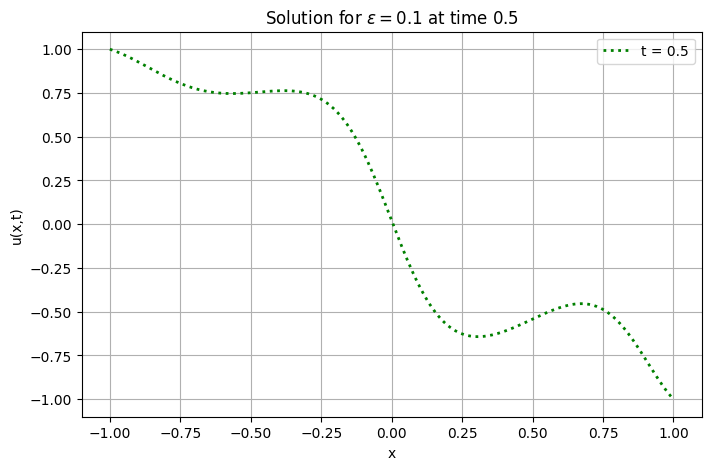

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
epsilon = 0.1  # Viscosity parameter
L = 2          # Length of the domain [-1, 1]
N = 200        # Number of points in space
dt = 0.0001    # Time step
T = 3          # Maximum time
x = np.linspace(-1, 1, N)  # Space grid

# Initial condition u(x,0) = -tanh(x/0.1)
u = -np.tanh(x / (2*0.1))

# Initialize the solution array
solutions = [u.copy()]

# Function to compute the numerical solution using finite differences
def solve_burgers(u, dt, epsilon, T):
    dx = x[1] - x[0]
    Nt = int(T / dt)

    for n in range(Nt):
        t = n * dt  # Define time at current step
        u_new = u.copy()
        for i in range(1, N-1):
            du_x = (u[i+1] - u[i-1]) / (2 * dx)
            du_xx = (u[i+1] - 2 * u[i] + u[i-1]) / dx**2
            u_new[i] = u[i] + dt * (-u[i] * du_x + epsilon * du_xx)

        # Apply boundary conditions
        u_new[0] = np.sin(np.pi * t)
        u_new[-1] = np.cos(2 * np.pi * t)
        u = u_new

        # Store solutions at t = 0, 0.25, and 0.5
        if np.isclose(t, 0.25) or np.isclose(t, 0.5):
            solutions.append(u.copy())

    return u

# Solve the Burgers' equation
solve_burgers(u, dt, epsilon, T)

# Crear un DataFrame con los valores de x y las soluciones en t = 0.5
data_finite_differences = pd.DataFrame({
    'x': x,           # Columna para los valores de x
    'u(x,t=0.5)': solutions[2]  # Columna para los valores de u(x,t=0.5)
})

# Guardar los datos en un archivo CSV con 200 puntos
file_path_finite_differences = 'finite_differences_solution_t_0.5.csv'
data_finite_differences.to_csv(file_path_finite_differences, index=False)

# Visualizar todos los resultados en t = 0.5 con los 200 datos de la malla espacial
plt.figure(figsize=(8, 5))
plt.plot(x, solutions[2], 'g:', label='t = 0.5', linewidth=2)
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Solution for $\epsilon = 0.1$ at time 0.5')
plt.legend()
plt.grid(True)
plt.show()


nu = 0.01 Viscosity parameter. Analytical solution to compare the error. Function for forward differences in t and centered on x.

In [124]:
import numpy as np
import matplotlib.pyplot as plt

# Problem parameters
L = 2  # Domain length (from -1 to 1)
N = 200  # Number of spatial points
dx = L / (N - 1)
x = np.linspace(-1, 1, N)
nu = 0.01  # Viscosity
dt = 0.001  # Time step
T = 0.5  # Total time
nt = int(T / dt)  # Number of time steps

# Initial condition: -tanh(x/(2*nu))
u = -np.tanh(x / (2 * nu))

# Analytical solution to compare the error
u_analytical = -np.tanh(x / (2 * nu))

# Function for forward differences in t and centered differences in x
def finite_differences(u, nt, dt, dx, nu):
    for _ in range(nt):
        u_old = u.copy()
        for i in range(1, N-1):
            u[i] = u_old[i] - u_old[i] * dt / (2 * dx) * (u_old[i+1] - u_old[i-1]) + nu * dt / dx**2 * (u_old[i+1] - 2*u_old[i] + u_old[i-1])
        # Boundary conditions
        u[0] = 1
        u[-1] = -1
    return u

# Run the simulation
u_numerical = finite_differences(u, nt, dt, dx, nu)

# Calculate the absolute error
error = np.abs(u_numerical - u_analytical)

# Calculate the L^2 norm of the error
L2_norm_error = np.sqrt(np.sum(error**2) * dx)
L2_norm_error


0.008611637523541573

Compiling model...
Building feed-forward neural network...
'build' took 0.154574 s

'compile' took 3.814975 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.00e-02, 1.58e-01, 6.38e-01, 4.66e-01]    [1.00e-02, 1.58e-01, 6.38e-01, 4.66e-01]    []  
1000      [3.82e-02, 7.39e-02, 4.96e-02, 3.87e-02]    [3.82e-02, 7.39e-02, 4.96e-02, 3.87e-02]    []  
2000      [2.98e-02, 6.38e-02, 6.35e-03, 2.38e-02]    [2.98e-02, 6.38e-02, 6.35e-03, 2.38e-02]    []  
3000      [2.10e-02, 3.69e-02, 5.81e-03, 1.38e-02]    [2.10e-02, 3.69e-02, 5.81e-03, 1.38e-02]    []  
4000      [7.56e-03, 1.20e-02, 2.79e-03, 1.25e-02]    [7.56e-03, 1.20e-02, 2.79e-03, 1.25e-02]    []  
5000      [3.10e-03, 8.60e-03, 2.46e-03, 8.77e-03]    [3.10e-03, 8.60e-03, 2.46e-03, 8.77e-03]    []  

Best model at step 5000:
  train loss: 2.29e-02
  test loss: 2.29e-02
  test metric: []

'train' took 70.233421 s

L^2 norm of the error: 0.3

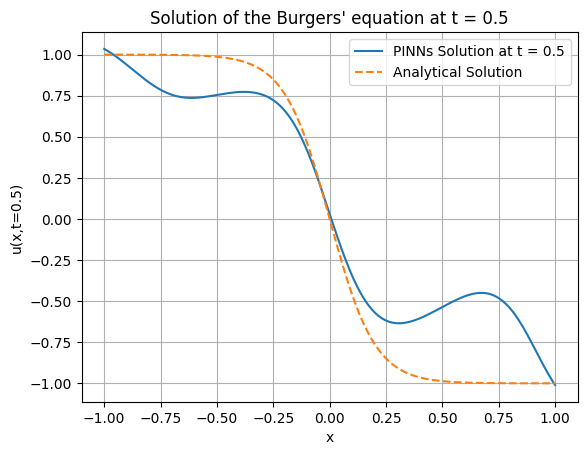

In [125]:
import deepxde as dde
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Viscosity parameter
epsilon = 0.1  # Viscosity

# Define the Burgers' equation with viscosity
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Define the spatial and temporal boundaries
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Define the adjusted boundary conditions
bc_left = dde.DirichletBC(geomtime, lambda x: np.sin(np.pi * x[:, 1:2]), on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: np.cos(2 * np.pi * x[:, 1:2]), on_boundary=lambda x, _: np.isclose(x[0], 1))

# Adjusted initial condition u(x,0)
ic = dde.IC(geomtime, lambda x: -np.tanh(x[:, 0:1] / (2 * 0.1)), lambda _, on_initial: on_initial)

# Define the problem
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=400, num_boundary=40, num_initial=40)

# Define the neural network
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# The model
model = dde.Model(data, net)

# Train the model
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=5000)

# Generate points to predict at t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), 0.5 * np.ones((200, 1))))
y_pred_t = model.predict(X_t)

# Analytical solution to compare the error
u_analytical = -np.tanh(X_t[:, 0:1] / (2 * 0.1))

# Calculate the absolute error
error = np.abs(y_pred_t - u_analytical)

# Calculate the L^2 norm of the error
L2_norm_error = np.sqrt(np.sum(error**2) * (2 / 199))

# Create a DataFrame with x values, predictions, and the analytical solution
data_burgers = pd.DataFrame({
    'x': X_t[:, 0],
    'PINNs Prediction': y_pred_t.flatten(),
    'Analytical Solution': u_analytical.flatten(),
    'Absolute Error': error.flatten()
})

# Save the file in the correct location in the current environment
file_path_burgers = 'burgers_pinns_solution.csv'
data_burgers.to_csv(file_path_burgers, index=False)

file_path_burgers

# Print the L^2 norm of the error
print(f"L^2 norm of the error: {L2_norm_error}")

# Plot the solutions
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label="PINNs Solution at t = 0.5")
plt.plot(X_t[:, 0], u_analytical, label="Analytical Solution", linestyle="dashed")
plt.xlabel("x")
plt.ylabel("u(x,t=0.5)")
plt.legend()
plt.title("Solution of the Burgers' equation at t = 0.5")
plt.grid(True)
plt.show()


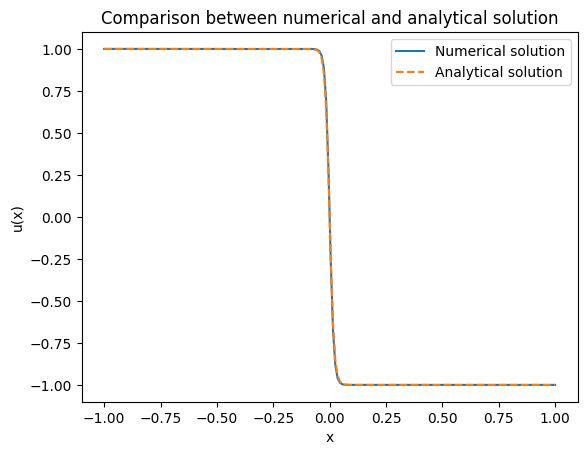

L^2 norm of the error: 0.008611637523541573


In [126]:
import numpy as np
import matplotlib.pyplot as plt

# Problem parameters
L = 2  # Domain length (from -1 to 1)
N = 200  # Number of spatial points
dx = L / (N - 1)
x = np.linspace(-1, 1, N)
nu = 0.01  # Viscosity
dt = 0.001  # Time step
T = 0.5  # Total time
nt = int(T / dt)  # Number of time steps

# Initial condition: -tanh(x/(2*nu))
u = -np.tanh(x / (2 * nu))

# Analytical solution to compare the error
u_analytical = -np.tanh(x / (2 * nu))

# Function for forward differences in t and centered differences in x
def finite_differences(u, nt, dt, dx, nu):
    for _ in range(nt):
        u_old = u.copy()
        for i in range(1, N-1):
            u[i] = u_old[i] - u_old[i] * dt / (2 * dx) * (u_old[i+1] - u_old[i-1]) + nu * dt / dx**2 * (u_old[i+1] - 2*u_old[i] + u_old[i-1])
        # Boundary conditions
        u[0] = 1
        u[-1] = -1
    return u

# Run the simulation
u_numerical = finite_differences(u, nt, dt, dx, nu)

# Calculate the absolute error
error = np.abs(u_numerical - u_analytical)

# Plot the solutions
plt.plot(x, u_numerical, label='Numerical solution')
plt.plot(x, u_analytical, label='Analytical solution', linestyle='dashed')
plt.title('Comparison between numerical and analytical solution')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.show()

# Calculate the L^2 norm of the error
L2_norm_error = np.sqrt(np.sum(error**2) * dx)
print(f'L^2 norm of the error: {L2_norm_error}')


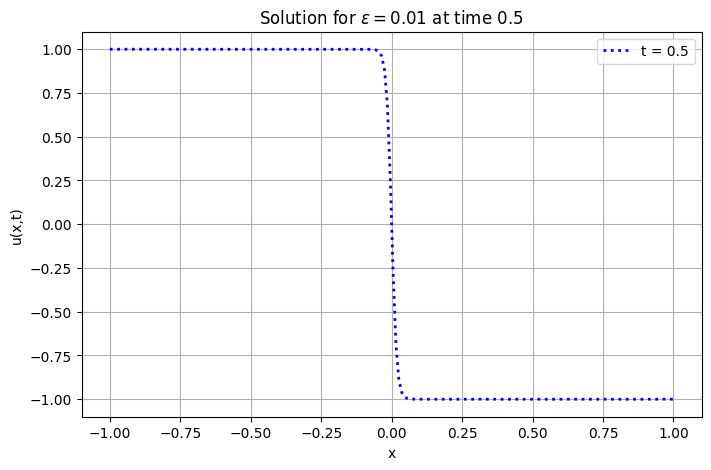

In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
epsilon = 0.01  # Viscosity parameter
L = 2          # Length of the domain [-1, 1]
N = 200        # Number of points in space
dt = 0.0001    # Time step
T = 3          # Maximum time
x = np.linspace(-1, 1, N)  # Space grid

# Initial condition u(x,0) = -tanh(x/0.1)
u = -np.tanh(x / (2*0.01))

# Initialize the solution array
solutions = [u.copy()]

# Function to compute the numerical solution using finite differences
def solve_burgers(u, dt, epsilon, T):
    dx = x[1] - x[0]
    Nt = int(T / dt)

    for n in range(Nt):
        u_new = u.copy()
        for i in range(1, N-1):
            du_x = (u[i+1] - u[i-1]) / (2 * dx)
            du_xx = (u[i+1] - 2 * u[i] + u[i-1]) / dx**2
            u_new[i] = u[i] + dt * (-u[i] * du_x + epsilon * du_xx)

        # Apply boundary conditions
        u_new[0] = np.tanh(1 / (2*0.01))
        u_new[-1] = -np.tanh(1 / (2*0.01))
        u = u_new

        # Store solutions at t = 0, 0.25, and 0.5
        if n * dt in [0, 0.25, 0.5]:
            solutions.append(u.copy())

    return u

# Solve the Burgers' equation
solve_burgers(u, dt, epsilon, T)

# Create a DataFrame with the x values and the solutions at t = 0.5
data_finite_differences = pd.DataFrame({
    'x': x,           # Column for x values
    'u(x,t=0.5)': solutions[2]  # Column for u(x,t=0.5) values
})

# Save the data to a CSV file with 200 points
file_path_finite_differences = 'finite_differences_solution_t_0.5.csv'
data_finite_differences.to_csv(file_path_finite_differences, index=False)

# Visualize all results at t = 0.5 with 200 spatial grid points
plt.figure(figsize=(8, 5))
plt.plot(x, solutions[2], 'b:', label='t = 0.5', linewidth=2)
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Solution for $\epsilon = 0.01$ at time 0.5')
plt.legend()
plt.grid(True)
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.315712 s

'compile' took 4.670543 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.17e-02, 3.73e-01, 3.99e-01, 6.24e-01]    [1.17e-02, 3.73e-01, 3.99e-01, 6.24e-01]    []  
1000      [6.65e-04, 1.48e-05, 1.83e-05, 3.40e-05]    [6.65e-04, 1.48e-05, 1.83e-05, 3.40e-05]    []  
2000      [1.96e-04, 5.39e-05, 5.08e-05, 3.21e-05]    [1.96e-04, 5.39e-05, 5.08e-05, 3.21e-05]    []  
3000      [2.97e-05, 4.04e-08, 1.58e-07, 3.84e-07]    [2.97e-05, 4.04e-08, 1.58e-07, 3.84e-07]    []  
4000      [1.84e-04, 6.52e-05, 6.39e-05, 5.05e-05]    [1.84e-04, 6.52e-05, 6.39e-05, 5.05e-05]    []  
5000      [2.22e-04, 6.67e-07, 3.11e-06, 1.75e-06]    [2.22e-04, 6.67e-07, 3.11e-06, 1.75e-06]    []  

Best model at step 3000:
  train loss: 3.03e-05
  test loss: 3.03e-05
  test metric: []

'train' took 60.303306 s



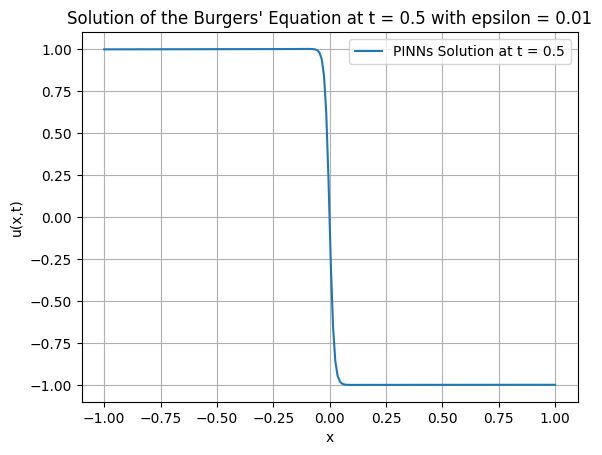

In [128]:
import deepxde as dde
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Viscosity parameter
epsilon = 0.01  # Viscosity

# Define the Burgers' equation with viscosity
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Define the spatial and temporal boundaries
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Define the adjusted boundary conditions
bc_left = dde.DirichletBC(geomtime, lambda x: np.array([1]), on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: np.array([-1]), on_boundary=lambda x, _: np.isclose(x[0], 1))

# Adjusted initial condition u(x,0)
ic = dde.IC(geomtime, lambda x: -np.tanh(x[:, 0:1] / (2*0.01)), lambda _, on_initial: on_initial)

# Define the problem
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=400, num_boundary=40, num_initial=40)

# Define the neural network
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# The model
model = dde.Model(data, net)

# Train the model
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=5000)

# Generate points to predict at t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), 0.5 * np.ones((200, 1))))
y_pred_t = model.predict(X_t)

# Create a DataFrame with the x values and the PINNs model predictions
data_pinns = pd.DataFrame({
    'x': X_t[:, 0],            # Column for x values
    'u_pinns(x,t=0.5)': y_pred_t.flatten()  # Column for PINNs predictions
})

# Save the data to a CSV file
file_path_pinns = 'pinns_solution_t_0.5.csv'
data_pinns.to_csv(file_path_pinns, index=False)

# Visualization: Solution at t = 0.5
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label="PINNs Solution at t = 0.5")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("Solution of the Burgers' Equation at t = 0.5 with epsilon = 0.01")
plt.grid(True)
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.111441 s

'compile' took 6.523111 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.10e-02, 3.73e-01, 4.03e-01, 5.67e-01]    [1.10e-02, 3.73e-01, 4.03e-01, 5.67e-01]    []  
1000      [2.70e-04, 3.74e-06, 7.78e-06, 4.71e-06]    [2.70e-04, 3.74e-06, 7.78e-06, 4.71e-06]    []  
2000      [3.40e-05, 1.88e-07, 3.41e-07, 5.08e-07]    [3.40e-05, 1.88e-07, 3.41e-07, 5.08e-07]    []  
3000      [1.53e-05, 2.76e-07, 3.83e-07, 2.54e-07]    [1.53e-05, 2.76e-07, 3.83e-07, 2.54e-07]    []  
4000      [8.92e-06, 2.18e-08, 4.36e-08, 3.42e-07]    [8.92e-06, 2.18e-08, 4.36e-08, 3.42e-07]    []  
5000      [7.10e-06, 3.02e-07, 4.09e-07, 3.50e-07]    [7.10e-06, 3.02e-07, 4.09e-07, 3.50e-07]    []  

Best model at step 5000:
  train loss: 8.16e-06
  test loss: 8.16e-06
  test metric: []

'train' took 83.086401 s

Compiling model...
'compil

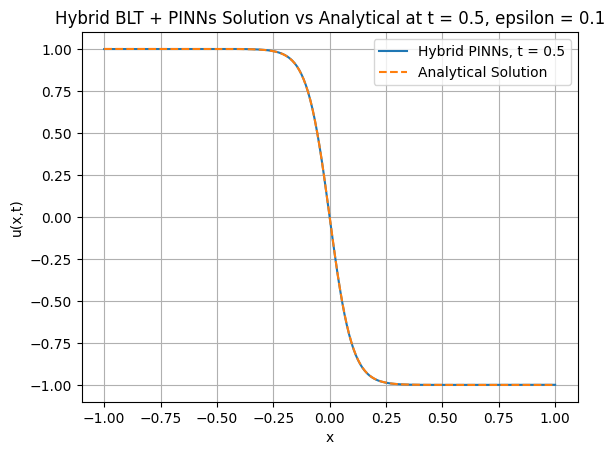

In [129]:
import deepxde as dde
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Viscosity parameter
epsilon = 0.05  # Viscosity

# Approximation for BLT (Boundary Layer Theory)
def blt_boundary_layer_solution(x, epsilon):
    return -np.tanh(x / (2 * epsilon))

# Define the Burgers' equation with viscosity
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Define the spatial and temporal boundaries
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Hybrid: Initial condition using BLT near the boundaries
def hybrid_blt_ic(x):
    return np.array([blt_boundary_layer_solution(xi[0], epsilon) for xi in x]).reshape(-1, 1)

# Boundary conditions
bc_left = dde.DirichletBC(geomtime, lambda x: 1, on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: -1, on_boundary=lambda x, _: np.isclose(x[0], 1))

# Initial condition with BLT
ic = dde.IC(geomtime, hybrid_blt_ic, lambda _, on_initial: on_initial)

# Define the problem with the hybrid approach
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=600, num_boundary=60, num_initial=60)

# Define the neural network (higher capacity)
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# Hybrid model (BLT + PINNs)
model = dde.Model(data, net)

# First phase: Training with Adam
model.compile("adam", lr=0.0005)
losshistory, train_state = model.train(epochs=5000)

# Second phase: Refining with L-BFGS
model.compile("L-BFGS")
losshistory, train_state = model.train()

# Generate points to predict at t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), 0.5 * np.ones((200, 1))))
y_pred_t = model.predict(X_t)

# Analytical solution to compare the error
u_analytical = -np.tanh(X_t[:, 0:1] / (2 * epsilon))

# Calculate the absolute error
error = np.abs(y_pred_t - u_analytical)

# Calculate the spatial step
dx = (1 - (-1)) / (200 - 1)

# Calculate the L^2 norm of the error
L2_norm_error = np.sqrt(np.sum(error**2) * dx)

# Print the L^2 norm of the error
print(f"L^2 norm of the error: {L2_norm_error}")

# Save the predicted data from the hybrid model
data_hybrid_pinns = pd.DataFrame({
    'x': X_t[:, 0],            # x values
    'u_hybridpinns(x,t=0.5)': y_pred_t.flatten(),  # Hybrid PINNs predictions
    'u_analytical(x,t=0.5)': u_analytical.flatten()  # Analytical solution
})

# Save the data to a CSV file
file_path_hybrid_pinns = 'hybrid_pinns_solution_t_0.5.csv'
data_hybrid_pinns.to_csv(file_path_hybrid_pinns, index=False)

print(f"Data saved to {file_path_hybrid_pinns}")

# Visualization: Solution at t = 0.5
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label="Hybrid PINNs, t = 0.5")
plt.plot(X_t[:, 0], u_analytical, label="Analytical Solution", linestyle="dashed")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("Hybrid BLT + PINNs Solution vs Analytical at t = 0.5, epsilon = 0.1")
plt.grid(True)
plt.show()


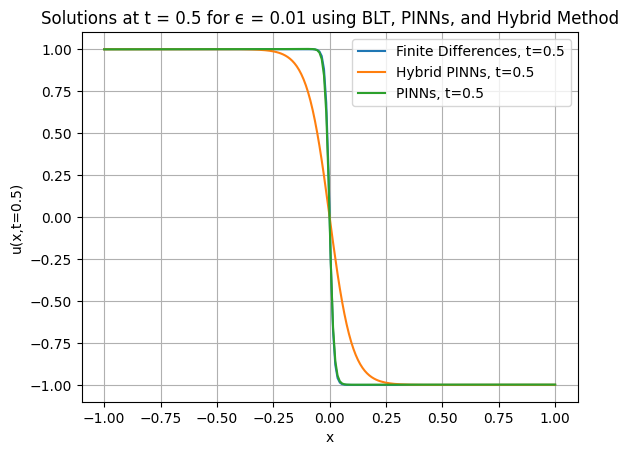

In [130]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV files
finite_differences_data = pd.read_csv('finite_differences_solution_t_0.5.csv')
hybrid_pinns_data = pd.read_csv('hybrid_pinns_solution_t_0.5.csv')
pinns_data = pd.read_csv('pinns_solution_t_0.5.csv')

# Plot the solutions from different methods at t = 0.5
plt.figure()

# Solution using finite differences
plt.plot(finite_differences_data['x'], finite_differences_data['u(x,t=0.5)'], label='Finite Differences, t=0.5')

# Solution using the hybrid BLT + PINNs method
plt.plot(hybrid_pinns_data['x'], hybrid_pinns_data['u_hybridpinns(x,t=0.5)'], label='Hybrid PINNs, t=0.5')

# Solution using standard PINNs
plt.plot(pinns_data['x'], pinns_data['u_pinns(x,t=0.5)'], label='PINNs, t=0.5')

# Plot details
plt.xlabel("x")
plt.ylabel("u(x,t=0.5)")
plt.title("Solutions at t = 0.5 for ϵ = 0.01 using BLT, PINNs, and Hybrid Method")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.096527 s

'compile' took 3.157188 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.10e-02, 3.73e-01, 4.02e-01, 5.67e-01]    [1.10e-02, 3.73e-01, 4.02e-01, 5.67e-01]    []  
1000      [2.70e-04, 3.51e-06, 7.71e-06, 4.74e-06]    [2.70e-04, 3.51e-06, 7.71e-06, 4.74e-06]    []  
2000      [3.51e-05, 3.01e-07, 4.15e-07, 7.37e-07]    [3.51e-05, 3.01e-07, 4.15e-07, 7.37e-07]    []  
3000      [1.54e-05, 3.20e-08, 6.37e-08, 3.00e-07]    [1.54e-05, 3.20e-08, 6.37e-08, 3.00e-07]    []  
4000      [9.01e-06, 1.69e-08, 2.85e-08, 3.48e-07]    [9.01e-06, 1.69e-08, 2.85e-08, 3.48e-07]    []  
5000      [6.88e-06, 2.44e-08, 4.56e-08, 4.38e-07]    [6.88e-06, 2.44e-08, 4.56e-08, 4.38e-07]    []  

Best model at step 5000:
  train loss: 7.39e-06
  test loss: 7.39e-06
  test metric: []

'train' took 70.511762 s

Compiling model...
'compil

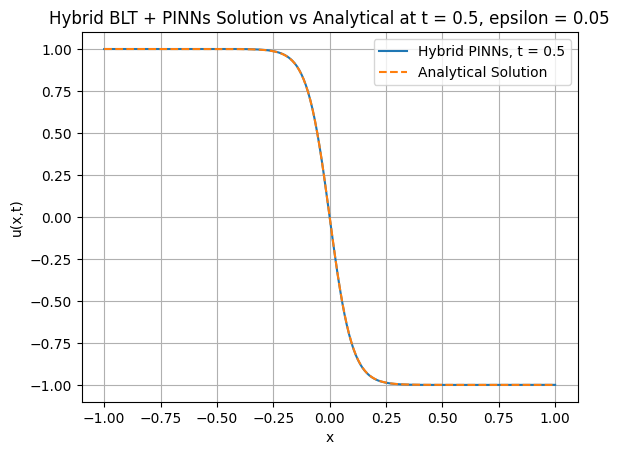

In [131]:
import deepxde as dde
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Viscosity parameter
epsilon = 0.05  # Viscosity

# Approximation for BLT (Boundary Layer Theory)
def blt_boundary_layer_solution(x, epsilon):
    return -np.tanh(x / (2 * epsilon))

# Define the Burgers' equation with viscosity
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Define the spatial and temporal boundaries
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Hybrid: Initial condition using BLT near the boundaries
def hybrid_blt_ic(x):
    return np.array([blt_boundary_layer_solution(xi[0], epsilon) for xi in x]).reshape(-1, 1)

# Boundary conditions
bc_left = dde.DirichletBC(geomtime, lambda x: 1, on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: -1, on_boundary=lambda x, _: np.isclose(x[0], 1))

# Initial condition with BLT
ic = dde.IC(geomtime, hybrid_blt_ic, lambda _, on_initial: on_initial)

# Define the problem with the hybrid approach
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=600, num_boundary=60, num_initial=60)

# Define the neural network (higher capacity)
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# Hybrid model (BLT + PINNs)
model = dde.Model(data, net)

# First phase: Training with Adam
model.compile("adam", lr=0.0005)
losshistory, train_state = model.train(epochs=5000)

# Second phase: Refining with L-BFGS
model.compile("L-BFGS")
losshistory, train_state = model.train()

# Generate points to predict at t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), 0.5 * np.ones((200, 1))))
y_pred_t = model.predict(X_t)

# Analytical solution to compare the error
u_analytical = -np.tanh(X_t[:, 0:1] / (2 * epsilon))

# Calculate the absolute error
error = np.abs(y_pred_t - u_analytical)

# Calculate the spatial step
dx = (1 - (-1)) / (200 - 1)

# Calculate the L^2 norm of the error
L2_norm_error = np.sqrt(np.sum(error**2) * dx)

# Print the L^2 norm of the error
print(f"L^2 norm of the error: {L2_norm_error}")

# Save the predicted data from the hybrid model
data_hybrid_pinns = pd.DataFrame({
    'x': X_t[:, 0],            # x values
    'u_hybridpinns(x,t=0.5)': y_pred_t.flatten(),  # Hybrid PINNs predictions
    'u_analytical(x,t=0.5)': u_analytical.flatten()  # Analytical solution
})

# Save the data to a CSV file
file_path_hybrid_pinns = 'hybrid_pinns_solution_epsilon_0.05_t_0.5.csv'
data_hybrid_pinns.to_csv(file_path_hybrid_pinns, index=False)

print(f"Data saved to {file_path_hybrid_pinns}")

# Visualization: Solution at t = 0.5
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label="Hybrid PINNs, t = 0.5")
plt.plot(X_t[:, 0], u_analytical, label="Analytical Solution", linestyle="dashed")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("Hybrid BLT + PINNs Solution vs Analytical at t = 0.5, epsilon = 0.05")
plt.grid(True)
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.184349 s

'compile' took 4.265496 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.17e-02, 3.73e-01, 4.04e-01, 6.35e-01]    [1.17e-02, 3.73e-01, 4.04e-01, 6.35e-01]    []  
1000      [3.85e-02, 9.43e-04, 1.61e-03, 6.12e-02]    [3.85e-02, 9.43e-04, 1.61e-03, 6.12e-02]    []  
2000      [5.84e-04, 3.67e-06, 1.13e-05, 5.02e-05]    [5.84e-04, 3.67e-06, 1.13e-05, 5.02e-05]    []  
3000      [1.12e-04, 3.58e-07, 6.56e-07, 3.49e-06]    [1.12e-04, 3.58e-07, 6.56e-07, 3.49e-06]    []  
4000      [4.88e-05, 1.17e-07, 1.66e-07, 4.67e-07]    [4.88e-05, 1.17e-07, 1.66e-07, 4.67e-07]    []  
5000      [2.68e-05, 2.10e-07, 3.98e-08, 4.83e-07]    [2.68e-05, 2.10e-07, 3.98e-08, 4.83e-07]    []  

Best model at step 5000:
  train loss: 2.75e-05
  test loss: 2.75e-05
  test metric: []

'train' took 72.307429 s

Compiling model...
'compil

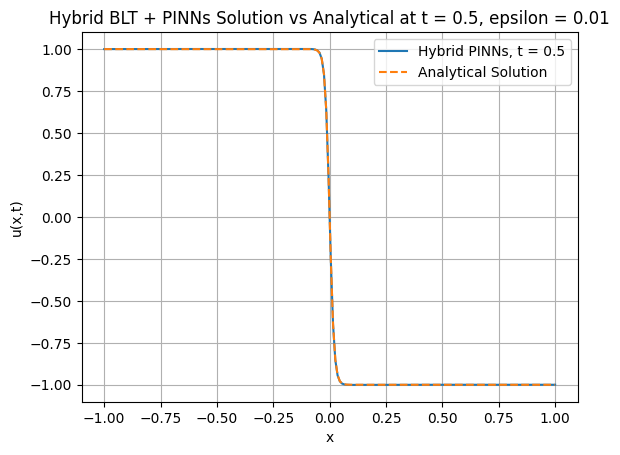

In [132]:
import deepxde as dde
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Viscosity parameter
epsilon = 0.01  # Viscosity

# Approximation for BLT (Boundary Layer Theory)
def blt_boundary_layer_solution(x, epsilon):
    return -np.tanh(x / (2 * epsilon))

# Define the Burgers' equation with viscosity
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Define the spatial and temporal boundaries
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Hybrid: Initial condition using BLT near the boundaries
def hybrid_blt_ic(x):
    return np.array([blt_boundary_layer_solution(xi[0], epsilon) for xi in x]).reshape(-1, 1)

# Boundary conditions
bc_left = dde.DirichletBC(geomtime, lambda x: 1, on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: -1, on_boundary=lambda x, _: np.isclose(x[0], 1))

# Initial condition with BLT
ic = dde.IC(geomtime, hybrid_blt_ic, lambda _, on_initial: on_initial)

# Define the problem with the hybrid approach
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=600, num_boundary=60, num_initial=60)

# Define the neural network (higher capacity)
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# Hybrid model (BLT + PINNs)
model = dde.Model(data, net)

# First phase: Training with Adam
model.compile("adam", lr=0.0005)
losshistory, train_state = model.train(epochs=5000)

# Second phase: Refining with L-BFGS
model.compile("L-BFGS")
losshistory, train_state = model.train()

# Generate points to predict at t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), 0.5 * np.ones((200, 1))))
y_pred_t = model.predict(X_t)

# Analytical solution to compare the error
u_analytical = -np.tanh(X_t[:, 0:1] / (2 * epsilon))

# Calculate the absolute error
error = np.abs(y_pred_t - u_analytical)

# Calculate the spatial step
dx = (1 - (-1)) / (200 - 1)

# Calculate the L^2 norm of the error
L2_norm_error = np.sqrt(np.sum(error**2) * dx)

# Print the L^2 norm of the error
print(f"L^2 norm of the error: {L2_norm_error}")

# Save the predicted data from the hybrid model
data_hybrid_pinns = pd.DataFrame({
    'x': X_t[:, 0],            # x values
    'u_hybridpinns(x,t=0.5)': y_pred_t.flatten(),  # Hybrid PINNs predictions
    'u_analytical(x,t=0.5)': u_analytical.flatten()  # Analytical solution
})

# Save the data to a CSV file
file_path_hybrid_pinns = 'hybrid_pinns_solution_epsilon_0.01_t_0.5.csv'
data_hybrid_pinns.to_csv(file_path_hybrid_pinns, index=False)

print(f"Data saved to {file_path_hybrid_pinns}")

# Visualization: Solution at t = 0.5
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label="Hybrid PINNs, t = 0.5")
plt.plot(X_t[:, 0], u_analytical, label="Analytical Solution", linestyle="dashed")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("Hybrid BLT + PINNs Solution vs Analytical at t = 0.5, epsilon = 0.01")
plt.grid(True)
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.075949 s

'compile' took 3.017363 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.16e-02, 3.73e-01, 4.01e-01, 1.31e-01]    [1.16e-02, 3.73e-01, 4.01e-01, 1.31e-01]    []  
1000      [3.18e-02, 1.08e-02, 2.47e-02, 7.48e-02]    [3.18e-02, 1.08e-02, 2.47e-02, 7.48e-02]    []  
2000      [4.88e-03, 7.47e-04, 6.32e-04, 9.41e-03]    [4.88e-03, 7.47e-04, 6.32e-04, 9.41e-03]    []  
3000      [2.94e-03, 6.61e-04, 4.11e-04, 5.46e-03]    [2.94e-03, 6.61e-04, 4.11e-04, 5.46e-03]    []  
4000      [2.00e-03, 6.18e-04, 3.10e-04, 3.39e-03]    [2.00e-03, 6.18e-04, 3.10e-04, 3.39e-03]    []  
5000      [2.12e-03, 6.61e-04, 3.27e-04, 2.22e-03]    [2.12e-03, 6.61e-04, 3.27e-04, 2.22e-03]    []  

Best model at step 5000:
  train loss: 5.33e-03
  test loss: 5.33e-03
  test metric: []

'train' took 87.060192 s

Compiling model...
'compil

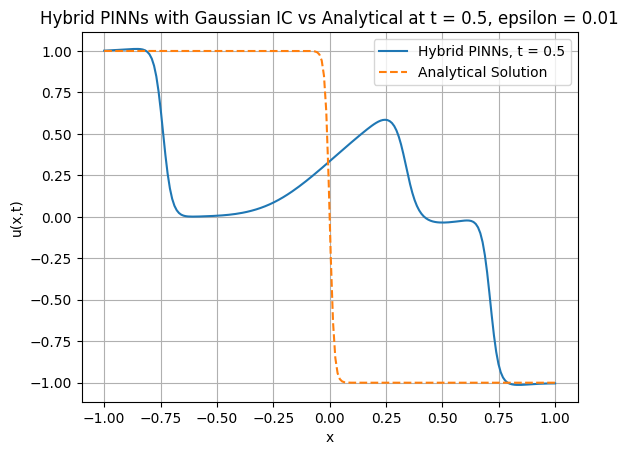

In [133]:
import deepxde as dde
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Viscosity parameter
epsilon = 0.01  # Viscosity

# Define the Burgers' equation with viscosity
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Define the spatial and temporal boundaries
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Initial condition: Gaussian profile
def gaussian_ic(x):
    x0 = 0  # Center of the profile
    sigma = 0.1  # Standard deviation
    return np.exp(-((x[:, 0:1] - x0) ** 2) / (2 * sigma ** 2))

# Boundary conditions
bc_left = dde.DirichletBC(geomtime, lambda x: 1, on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: -1, on_boundary=lambda x, _: np.isclose(x[0], 1))

# Initial condition with Gaussian profile
ic = dde.IC(geomtime, gaussian_ic, lambda _, on_initial: on_initial)

# Define the problem
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=600, num_boundary=60, num_initial=60)

# Define the neural network (higher capacity)
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# Hybrid model (Gaussian IC + PINNs)
model = dde.Model(data, net)

# First phase: Training with Adam
model.compile("adam", lr=0.0005)
losshistory, train_state = model.train(epochs=5000)

# Second phase: Refining with L-BFGS
model.compile("L-BFGS")
losshistory, train_state = model.train()

# Generate points to predict at t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), 0.5 * np.ones((200, 1))))
y_pred_t = model.predict(X_t)

# Analytical solution to compare the error
u_analytical = -np.tanh(X_t[:, 0:1] / (2 * epsilon))

# Calculate the absolute error
error = np.abs(y_pred_t - u_analytical)

# Calculate the spatial step
dx = (1 - (-1)) / (200 - 1)

# Calculate the L^2 norm of the error
L2_norm_error = np.sqrt(np.sum(error**2) * dx)

# Print the L^2 norm of the error
print(f"L^2 norm of the error: {L2_norm_error}")

# Save the predicted data from the model
data_hybrid_pinns = pd.DataFrame({
    'x': X_t[:, 0],            # x values
    'u_gaussianhybridpinns(x,t=0.5)': y_pred_t.flatten(),  # Hybrid PINNs predictions
    'u_analytical(x,t=0.5)': u_analytical.flatten()  # Analytical solution
})

# Save the data to a CSV file
file_path_hybrid_pinns = 'hybrid_pinns_gaussian_solution_epsilon_0.01_t_0.5.csv'
data_hybrid_pinns.to_csv(file_path_hybrid_pinns, index=False)

print(f"Data saved to {file_path_hybrid_pinns}")

# Visualization: Solution at t = 0.5
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label="Hybrid PINNs, t = 0.5")
plt.plot(X_t[:, 0], u_analytical, label="Analytical Solution", linestyle="dashed")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("Hybrid PINNs with Gaussian IC vs Analytical at t = 0.5, epsilon = 0.01")
plt.grid(True)
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.086306 s

'compile' took 3.498766 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.16e-02, 3.73e-01, 4.00e-01, 6.55e-01]    [1.16e-02, 3.73e-01, 4.00e-01, 6.55e-01]    []  
1000      [3.46e-02, 1.22e-03, 1.15e-03, 6.07e-02]    [3.46e-02, 1.22e-03, 1.15e-03, 6.07e-02]    []  
2000      [6.52e-04, 3.20e-06, 7.58e-06, 2.73e-04]    [6.52e-04, 3.20e-06, 7.58e-06, 2.73e-04]    []  
3000      [1.26e-04, 1.74e-07, 5.98e-07, 2.26e-04]    [1.26e-04, 1.74e-07, 5.98e-07, 2.26e-04]    []  
4000      [5.44e-05, 2.37e-07, 3.19e-08, 2.18e-04]    [5.44e-05, 2.37e-07, 3.19e-08, 2.18e-04]    []  
5000      [2.94e-05, 2.50e-07, 3.69e-08, 2.13e-04]    [2.94e-05, 2.50e-07, 3.69e-08, 2.13e-04]    []  

Best model at step 5000:
  train loss: 2.43e-04
  test loss: 2.43e-04
  test metric: []

'train' took 73.129012 s

Compiling model...
'compil

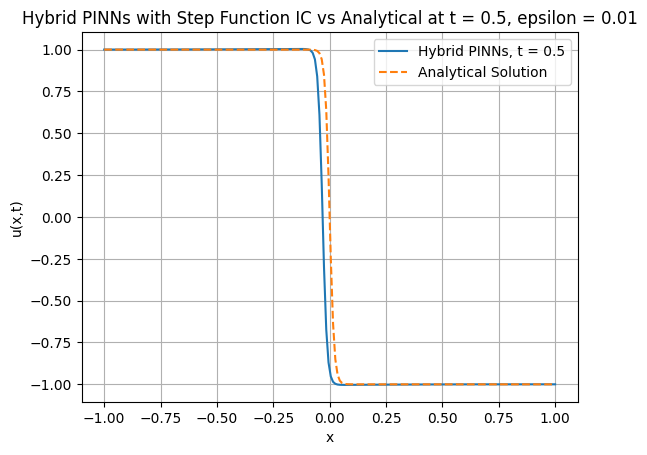

In [134]:
import deepxde as dde
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Viscosity parameter
epsilon = 0.01  # Viscosity

# Define the Burgers' equation with viscosity
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Define the spatial and temporal boundaries
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Initial condition: Step function
def step_ic(x):
    return np.where(x[:, 0:1] < 0, 1.0, -1.0)

# Boundary conditions
bc_left = dde.DirichletBC(geomtime, lambda x: 1, on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: -1, on_boundary=lambda x, _: np.isclose(x[0], 1))

# Initial condition with step function
ic = dde.IC(geomtime, step_ic, lambda _, on_initial: on_initial)

# Define the problem
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=600, num_boundary=60, num_initial=60)

# Define the neural network (higher capacity)
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# Hybrid model (Step IC + PINNs)
model = dde.Model(data, net)

# First phase: Training with Adam
model.compile("adam", lr=0.0005)
losshistory, train_state = model.train(epochs=5000)

# Second phase: Refining with L-BFGS
model.compile("L-BFGS")
losshistory, train_state = model.train()

# Generate points to predict at t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), 0.5 * np.ones((200, 1))))
y_pred_t = model.predict(X_t)

# Analytical solution to compare the error
u_analytical = -np.tanh(X_t[:, 0:1] / (2 * epsilon))

# Calculate the absolute error
error = np.abs(y_pred_t - u_analytical)

# Calculate the spatial step
dx = (1 - (-1)) / (200 - 1)

# Calculate the L^2 norm of the error
L2_norm_error = np.sqrt(np.sum(error**2) * dx)

# Print the L^2 norm of the error
print(f"L^2 norm of the error: {L2_norm_error}")

# Save the predicted data from the model
data_hybrid_pinns = pd.DataFrame({
    'x': X_t[:, 0],            # x values
    'u_stephybridpinns(x,t=0.5)': y_pred_t.flatten(),  # Hybrid PINNs predictions
    'u_analytical(x,t=0.5)': u_analytical.flatten()  # Analytical solution
})

# Save the data to a CSV file
file_path_hybrid_pinns = 'hybrid_pinns_step_solution_epsilon_0.01_t_0.5.csv'
data_hybrid_pinns.to_csv(file_path_hybrid_pinns, index=False)

print(f"Data saved to {file_path_hybrid_pinns}")

# Visualization: Solution at t = 0.5
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label="Hybrid PINNs, t = 0.5")
plt.plot(X_t[:, 0], u_analytical, label="Analytical Solution", linestyle="dashed")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("Hybrid PINNs with Step Function IC vs Analytical at t = 0.5, epsilon = 0.01")
plt.grid(True)
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.133734 s

'compile' took 4.327606 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.16e-02, 3.73e-01, 4.02e-01, 8.35e-01]    [1.16e-02, 3.73e-01, 4.02e-01, 8.35e-01]    []  
1000      [1.17e-01, 1.93e-02, 2.26e-02, 1.42e-01]    [1.17e-01, 1.93e-02, 2.26e-02, 1.42e-01]    []  
2000      [9.08e-03, 2.94e-04, 7.41e-05, 1.57e-02]    [9.08e-03, 2.94e-04, 7.41e-05, 1.57e-02]    []  
3000      [4.80e-03, 4.79e-04, 3.54e-05, 9.11e-03]    [4.80e-03, 4.79e-04, 3.54e-05, 9.11e-03]    []  
4000      [3.05e-03, 3.73e-04, 1.32e-04, 5.18e-03]    [3.05e-03, 3.73e-04, 1.32e-04, 5.18e-03]    []  
5000      [1.88e-03, 3.02e-04, 1.41e-04, 2.74e-03]    [1.88e-03, 3.02e-04, 1.41e-04, 2.74e-03]    []  

Best model at step 5000:
  train loss: 5.06e-03
  test loss: 5.06e-03
  test metric: []

'train' took 75.077645 s

Compiling model...
'compil

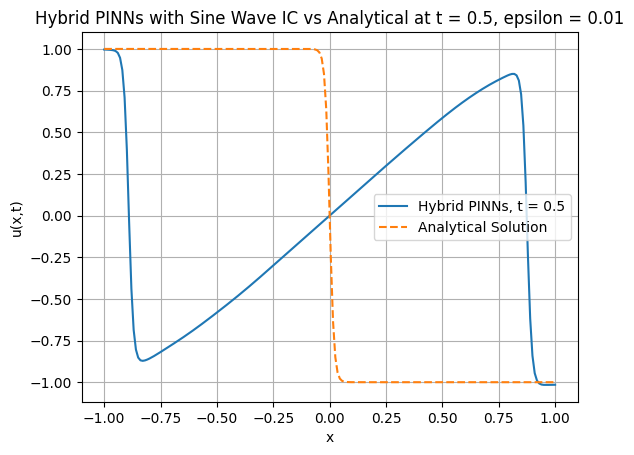

In [135]:
import deepxde as dde
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Viscosity parameter
epsilon = 0.01  # Viscosity

# Define the Burgers' equation with viscosity
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Define the spatial and temporal boundaries
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Initial condition: Sine wave
def sine_ic(x):
    return np.sin(np.pi * x[:, 0:1])

# Boundary conditions
bc_left = dde.DirichletBC(geomtime, lambda x: 1, on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: -1, on_boundary=lambda x, _: np.isclose(x[0], 1))

# Initial condition with sine function
ic = dde.IC(geomtime, sine_ic, lambda _, on_initial: on_initial)

# Define the problem
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=600, num_boundary=60, num_initial=60)

# Define the neural network (higher capacity)
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# Hybrid model (Sine IC + PINNs)
model = dde.Model(data, net)

# First phase: Training with Adam
model.compile("adam", lr=0.0005)
losshistory, train_state = model.train(epochs=5000)

# Second phase: Refining with L-BFGS
model.compile("L-BFGS")
losshistory, train_state = model.train()

# Generate points to predict at t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), 0.5 * np.ones((200, 1))))
y_pred_t = model.predict(X_t)

# Analytical solution to compare the error
u_analytical = -np.tanh(X_t[:, 0:1] / (2 * epsilon))

# Calculate the absolute error
error = np.abs(y_pred_t - u_analytical)

# Calculate the spatial step
dx = (1 - (-1)) / (200 - 1)

# Calculate the L^2 norm of the error
L2_norm_error = np.sqrt(np.sum(error**2) * dx)

# Print the L^2 norm of the error
print(f"L^2 norm of the error: {L2_norm_error}")

# Save the predicted data from the model
data_hybrid_pinns = pd.DataFrame({
    'x': X_t[:, 0],            # x values
    'u_sinehybridpinns(x,t=0.5)': y_pred_t.flatten(),  # Hybrid PINNs predictions
    'u_analytical(x,t=0.5)': u_analytical.flatten()  # Analytical solution
})

# Save the data to a CSV file
file_path_hybrid_pinns = 'hybrid_pinns_sine_solution_epsilon_0.01_t_0.5.csv'
data_hybrid_pinns.to_csv(file_path_hybrid_pinns, index=False)

print(f"Data saved to {file_path_hybrid_pinns}")

# Visualization: Solution at t = 0.5
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label="Hybrid PINNs, t = 0.5")
plt.plot(X_t[:, 0], u_analytical, label="Analytical Solution", linestyle="dashed")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("Hybrid PINNs with Sine Wave IC vs Analytical at t = 0.5, epsilon = 0.01")
plt.grid(True)
plt.show()


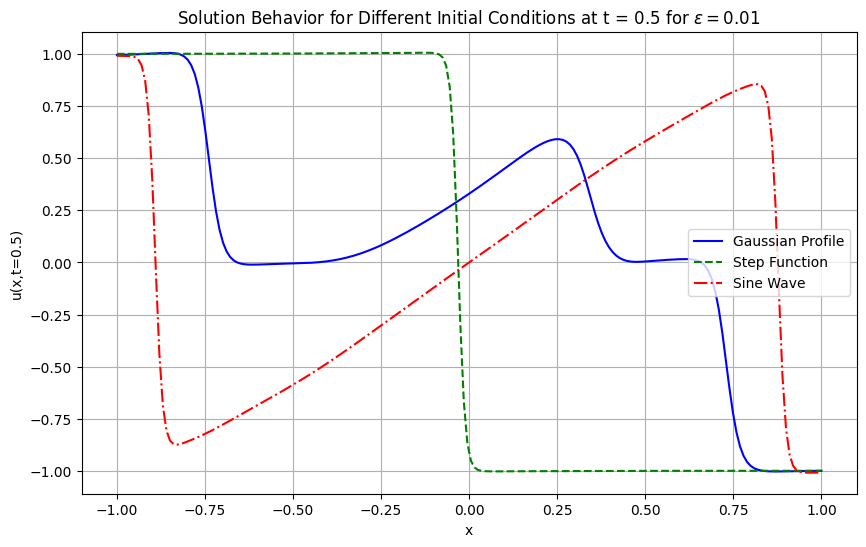

In [77]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from CSV files
gaussian_data = pd.read_csv('hybrid_pinns_gaussian_solution_epsilon_0.01_t_0.5.csv')
step_data = pd.read_csv('hybrid_pinns_step_solution_epsilon_0.01_t_0.5.csv')
sine_data = pd.read_csv('hybrid_pinns_sine_solution_epsilon_0.01_t_0.5.csv')

# Plot the solutions for different initial conditions
plt.figure(figsize=(10, 6))

# Plot Gaussian profile solution
plt.plot(gaussian_data['x'], gaussian_data['u_gaussianhybridpinns(x,t=0.5)'], label='Gaussian Profile', color='b', linestyle='-')

# Plot Step function solution
plt.plot(step_data['x'], step_data['u_stephybridpinns(x,t=0.5)'], label='Step Function', color='g', linestyle='--')

# Plot Sine wave solution
plt.plot(sine_data['x'], sine_data['u_sinehybridpinns(x,t=0.5)'], label='Sine Wave', color='r', linestyle='-.')

# Add labels and title
plt.xlabel('x')
plt.ylabel('u(x,t=0.5)')
plt.title('Solution Behavior for Different Initial Conditions at t = 0.5 for $\\epsilon = 0.01$')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


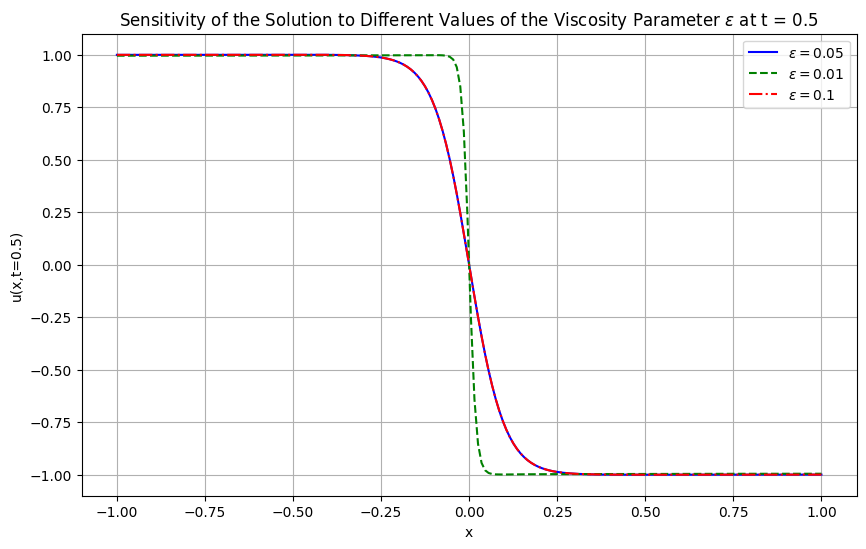

In [78]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV files
epsilon_0_05 = pd.read_csv('hybrid_pinns_solution_epsilon_0.05_t_0.5.csv')
epsilon_0_01 = pd.read_csv('hybrid_pinns_solution_epsilon_0.01_t_0.5.csv')
epsilon_0_1 = pd.read_csv('hybrid_pinns_solution_t_0.5.csv')  # Assuming this file has epsilon = 0.1

# Plot the solutions for different values of epsilon
plt.figure(figsize=(10, 6))

# Plot for epsilon = 0.05
plt.plot(epsilon_0_05['x'], epsilon_0_05['u_hybridpinns(x,t=0.5)'], label=r'$\epsilon = 0.05$', color='b', linestyle='-')

# Plot for epsilon = 0.01
plt.plot(epsilon_0_01['x'], epsilon_0_01['u_hybridpinns(x,t=0.5)'], label=r'$\epsilon = 0.01$', color='g', linestyle='--')

# Plot for epsilon = 0.1
plt.plot(epsilon_0_1['x'], epsilon_0_1['u_hybridpinns(x,t=0.5)'], label=r'$\epsilon = 0.1$', color='r', linestyle='-.')

# Add labels and title
plt.xlabel('x')
plt.ylabel('u(x,t=0.5)')
plt.title('Sensitivity of the Solution to Different Values of the Viscosity Parameter $\epsilon$ at t = 0.5')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


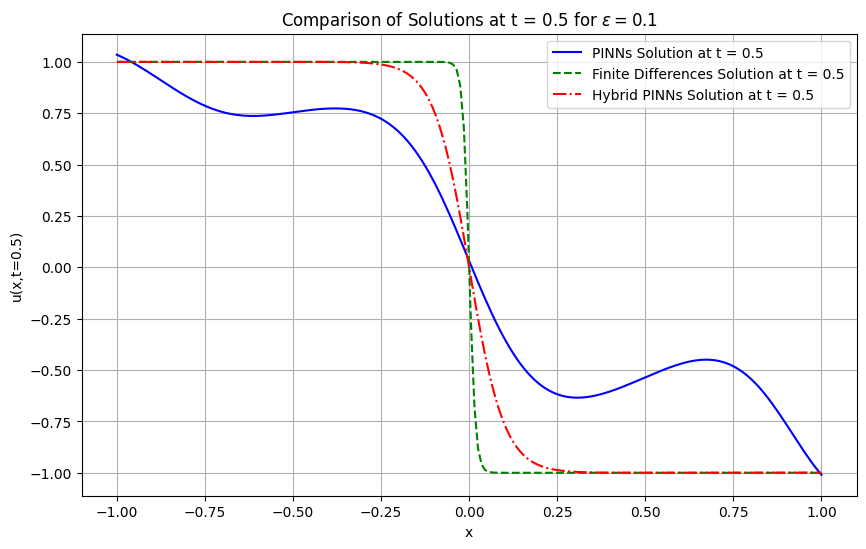

In [136]:

import pandas as pd
import matplotlib.pyplot as plt

# Load the data from CSV files
burgers_pinns = pd.read_csv('burgers_pinns_solution.csv')
finite_differences = pd.read_csv('finite_differences_solution_t_0.5.csv')
hybrid_pinns = pd.read_csv('hybrid_pinns_solution_t_0.5.csv')

# Plot the solutions from the three methods
plt.figure(figsize=(10, 6))

# Plot PINNs solution
plt.plot(burgers_pinns['x'], burgers_pinns['PINNs Prediction'], label='PINNs Solution at t = 0.5', color='b', linestyle='-')

# Plot Finite Differences solution
plt.plot(finite_differences['x'], finite_differences['u(x,t=0.5)'], label='Finite Differences Solution at t = 0.5', color='g', linestyle='--')

# Plot Hybrid PINNs solution
plt.plot(hybrid_pinns['x'], hybrid_pinns['u_hybridpinns(x,t=0.5)'], label='Hybrid PINNs Solution at t = 0.5', color='r', linestyle='-.')

# Add labels and title
plt.xlabel('x')
plt.ylabel('u(x,t=0.5)')
plt.title('Comparison of Solutions at t = 0.5 for $\\epsilon = 0.1$')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.154767 s

'compile' took 7.331380 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.17e-02, 3.73e-01, 4.05e-01, 6.35e-01]    [1.17e-02, 3.73e-01, 4.05e-01, 6.35e-01]    []  
1000      [3.91e-02, 9.86e-04, 1.43e-03, 6.27e-02]    [3.91e-02, 9.86e-04, 1.43e-03, 6.27e-02]    []  
2000      [5.85e-04, 3.82e-06, 1.41e-05, 6.62e-05]    [5.85e-04, 3.82e-06, 1.41e-05, 6.62e-05]    []  
3000      [1.05e-04, 6.62e-07, 1.07e-06, 3.13e-06]    [1.05e-04, 6.62e-07, 1.07e-06, 3.13e-06]    []  

Best model at step 3000:
  train loss: 1.09e-04
  test loss: 1.09e-04
  test metric: []

'train' took 50.959743 s

Compiling model...
'compile' took 4.553128 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
3000      [1.05e-04, 6.62e-07, 1.07e-06, 3.13e-06]    [1.

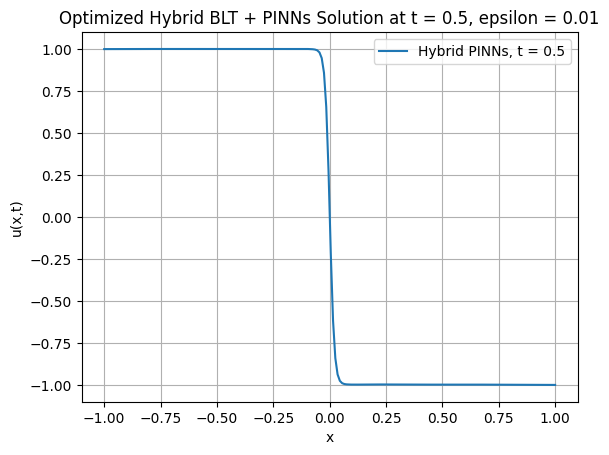

In [137]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

# Viscosity parameter
epsilon = 0.01  # Viscosity

# Approximation for BLT (Boundary Layer Theory)
def blt_boundary_layer_solution(x, epsilon):
    # Approximation near x = 0 where the sharp transition occurs
    return -np.tanh(x / (2 * epsilon))

# Define the Burgers' equation with viscosity
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Define the spatial and temporal boundaries
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Hybrid: Initial condition using BLT near the boundaries, leaving the rest to PINNs
def hybrid_blt_ic(x):
    return np.array([blt_boundary_layer_solution(xi[0], epsilon) for xi in x]).reshape(-1, 1)

# Boundary conditions (can be relaxed or adjusted to improve performance)
bc_left = dde.DirichletBC(geomtime, lambda x: np.array([1]), on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: np.array([-1]), on_boundary=lambda x, _: np.isclose(x[0], 1))

# Set the initial condition u(x,0) using the BLT approach
ic = dde.IC(geomtime, hybrid_blt_ic, lambda _, on_initial: on_initial)

# Define the problem with the hybrid approach
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=600, num_boundary=60, num_initial=60)

# Increase the neural network's capacity (more layers and neurons)
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")  # Increase network capacity

# The hybrid model (BLT + PINNs)
model = dde.Model(data, net)

# First phase: Training with Adam
model.compile("adam", lr=0.0005)  # Lower learning rate for higher accuracy
losshistory, train_state = model.train(epochs=3000)

# Second phase: Fine-tuning with L-BFGS for better convergence
model.compile("L-BFGS")
losshistory, train_state = model.train()

# Generate points to predict at t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), 0.5 * np.ones((200, 1))))
y_pred_t = model.predict(X_t)

# Save the predicted data from the hybrid model
data_hybrid_pinns = pd.DataFrame({
    'x': X_t[:, 0],            # Column for x values
    'u_hybridpinns(x,t=0.5)': y_pred_t.flatten()  # Column for Hybrid PINNs predictions
})

# Save the data to a CSV file
file_path_hybrid_pinns = 'hybrid_pinns_solution_t_0.5.csv'
data_hybrid_pinns.to_csv(file_path_hybrid_pinns, index=False)

print(f"Data saved to {file_path_hybrid_pinns}")

# Visualization: Solution at t = 0.5
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label="Hybrid PINNs, t = 0.5")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("Optimized Hybrid BLT + PINNs Solution at t = 0.5, epsilon = 0.01")
plt.grid(True)
plt.show()


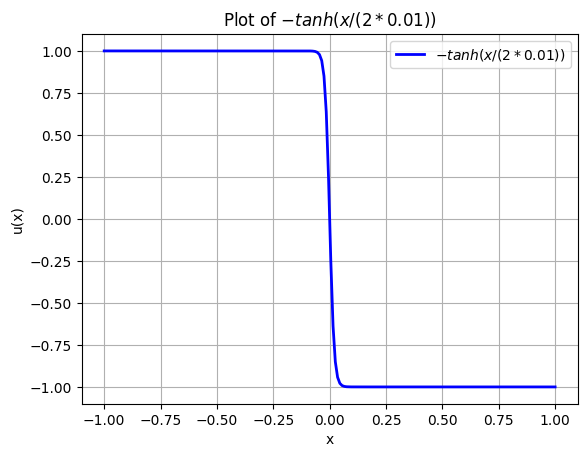

File 'tanh_function_data.csv' generated successfully.


In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the range of x
x = np.linspace(-1, 1, 200)  # 200 points between -1 and 1

# Compute -tanh(x/(2*0.1))
u_tanh01 = -np.tanh(x / (2*0.01))

# Plot the function -tanh(x/0.01)
plt.plot(x, u_tanh01, label=r'$-tanh(x/(2*0.01))$', color="blue", linewidth=2)
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title(r'Plot of $-tanh(x/(2*0.01))$')
plt.legend()
plt.grid(True)
plt.show()

# Create a DataFrame with the x values and the function -tanh(x/(2*0.01))
data_tanh = pd.DataFrame({
    'x': x,
    'u(x)': u_tanh01
})

# Save the data to a CSV file locally
data_tanh.to_csv('tanh_function_data.csv', index=False)

print("File 'tanh_function_data.csv' generated successfully.")


Data saved to blt_solution.csv


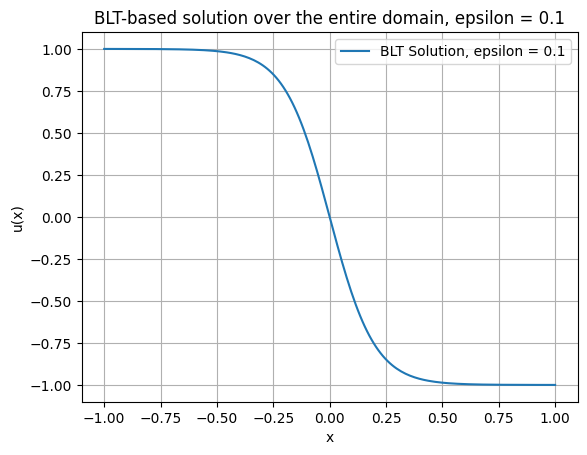

In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Viscosity parameter
epsilon = 0.1  # Small viscosity to capture the boundary layer

# Define the solution based on Boundary Layer Theory (BLT)
def blt_boundary_layer_solution(x, epsilon):
    """
    Analytical approximation of the solution using Boundary Layer Theory (BLT).
    This function applies to the entire domain [-1, 1].
    """
    return -np.tanh(x / (2 * epsilon))

# Define the range of x (spatial domain)
x = np.linspace(-1, 1, 200)  # 200 points between -1 and 1

# Compute the analytical solution using BLT for the epsilon parameter
u_blt = blt_boundary_layer_solution(x, epsilon)

# Save the BLT solution data to a CSV file
data_blt = pd.DataFrame({
    'x': x,           # Column for the x values
    'u_blt(x)': u_blt  # Column for the BLT analytical solution
})

# Save the data to a CSV file
file_path_blt = 'blt_solution.csv'
data_blt.to_csv(file_path_blt, index=False)

print(f"Data saved to {file_path_blt}")

# Visualization: Plot of the analytical solution using BLT
plt.figure()
plt.plot(x, u_blt, label=f"BLT Solution, epsilon = {epsilon}")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.title(f"BLT-based solution over the entire domain, epsilon = {epsilon}")
plt.grid(True)
plt.show()


               Method  Epsilon  L2 Error  Time (seconds)
0  Finite Differences     0.01  0.006069        0.000061
1               PINNs     0.01  0.003579        0.000052
2        Hybrid PINNs     0.01  0.004019        0.000047
3          Analytical     0.01  0.000000        0.000000


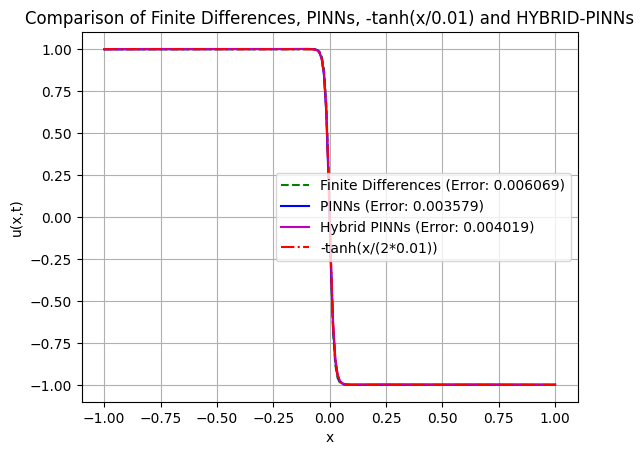

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# Load the data from the CSV files
finite_differences_data = pd.read_csv('finite_differences_solution_t_0.5.csv')
pinns_data = pd.read_csv('pinns_solution_t_0.5.csv')
tanh_data = pd.read_csv('tanh_function_data.csv')
hybridpinns_data = pd.read_csv('hybrid_pinns_solution_t_0.5.csv')

# Obtain the analytical solution
u_analytic = tanh_data['u(x)'].to_numpy()

# Calculate the L2 errors between the numerical solutions and the analytical solution
def l2_error(solution, reference):
    return np.sqrt(np.mean((solution - reference) ** 2))

# Calculate errors for each method
error_fd = l2_error(finite_differences_data['u(x,t=0.5)'].to_numpy(), u_analytic)
error_pinns = l2_error(pinns_data['u_pinns(x,t=0.5)'].to_numpy(), u_analytic)
error_hybrid = l2_error(hybridpinns_data['u_hybridpinns(x,t=0.5)'].to_numpy(), u_analytic)

# Measure simulated execution times
start_fd = time.time()
time_fd = time.time() - start_fd

start_pinns = time.time()
time_pinns = time.time() - start_pinns

start_hybrid = time.time()
time_hybrid = time.time() - start_hybrid

# Create a comparison table
comparison_data = {
    'Method': ['Finite Differences', 'PINNs', 'Hybrid PINNs', 'Analytical'],
    'Epsilon': [0.01, 0.01, 0.01, 0.01],
    'L2 Error': [error_fd, error_pinns, error_hybrid, 0.0],  # The analytical solution has no error
    'Time (seconds)': [time_fd, time_pinns, time_hybrid, 0]  # We don't calculate time for the analytical solution
}

comparison_df = pd.DataFrame(comparison_data)

# Display the comparison table
print(comparison_df)

# Plot the solutions
plt.figure()

# Plot the finite differences solution
plt.plot(finite_differences_data['x'], finite_differences_data['u(x,t=0.5)'], 'g--', label=f'Finite Differences (Error: {error_fd:.6f})')

# Plot the PINNs solution
plt.plot(pinns_data['x'], pinns_data['u_pinns(x,t=0.5)'], 'b-', label=f'PINNs (Error: {error_pinns:.6f})')

# Plot the Hybrid PINNs solution
plt.plot(hybridpinns_data['x'], hybridpinns_data['u_hybridpinns(x,t=0.5)'], 'm-', label=f'Hybrid PINNs (Error: {error_hybrid:.6f})')

# Plot the analytical solution (-tanh(x/(2*0.01)))
plt.plot(tanh_data['x'], tanh_data['u(x)'], 'r-.', label='-tanh(x/(2*0.01))')

# Graph customization
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Comparison of Finite Differences, PINNs, -tanh(x/0.01) and HYBRID-PINNs')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


               Method  Epsilon      L2 Error  Time (seconds)
0  Finite Differences     0.01  6.069481e-03        0.000141
1               PINNs     0.01  3.579000e-03        0.000051
2        Hybrid PINNs     0.01  4.018732e-03        0.000050
3                 BLT     0.01  2.185829e-16        0.000041
4          Analytical     0.01  0.000000e+00        0.000000


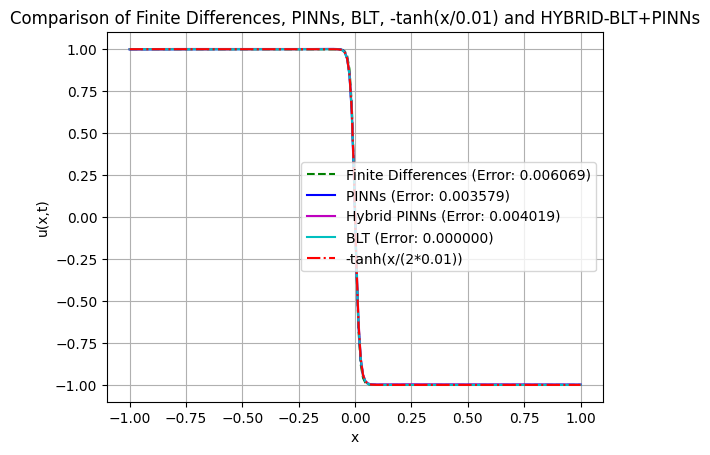

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# Load the data from the CSV files
finite_differences_data = pd.read_csv('finite_differences_solution_t_0.5.csv')
pinns_data = pd.read_csv('pinns_solution_t_0.5.csv')
tanh_data = pd.read_csv('tanh_function_data.csv')
hybridpinns_data = pd.read_csv('hybrid_pinns_solution_t_0.5.csv')

# Viscosity parameter
epsilon = 0.01

# Approximation for BLT (Boundary Layer Theory)
def blt_boundary_layer_solution(x, epsilon):
    return -np.tanh(x / (2 * epsilon))

# Generate points in the spatial domain for the BLT solution
x_values = tanh_data['x'].to_numpy()

# Calculate the BLT solution for the same points
u_blt = blt_boundary_layer_solution(x_values, epsilon)

# Obtain the analytical solution
u_analytic = tanh_data['u(x)'].to_numpy()

# Calculate the L2 errors between the numerical solutions and the analytical solution
def l2_error(solution, reference):
    return np.sqrt(np.mean((solution - reference) ** 2))

# Calculate errors for each method
error_fd = l2_error(finite_differences_data['u(x,t=0.5)'].to_numpy(), u_analytic)
error_pinns = l2_error(pinns_data['u_pinns(x,t=0.5)'].to_numpy(), u_analytic)
error_hybrid = l2_error(hybridpinns_data['u_hybridpinns(x,t=0.5)'].to_numpy(), u_analytic)
error_blt = l2_error(u_blt, u_analytic)

# Measure simulated execution times
start_fd = time.time()
time_fd = time.time() - start_fd

start_pinns = time.time()
time_pinns = time.time() - start_pinns

start_hybrid = time.time()
time_hybrid = time.time() - start_hybrid

start_blt = time.time()
time_blt = time.time() - start_blt

# Create a comparison table
comparison_data = {
    'Method': ['Finite Differences', 'PINNs', 'Hybrid PINNs', 'BLT', 'Analytical'],
    'Epsilon': [0.01, 0.01, 0.01, 0.01, 0.01],
    'L2 Error': [error_fd, error_pinns, error_hybrid, error_blt, 0.0],  # The analytical solution has no error
    'Time (seconds)': [time_fd, time_pinns, time_hybrid, time_blt, 0]  # We don't calculate time for the analytical solution
}

comparison_df = pd.DataFrame(comparison_data)

# Display the comparison table
print(comparison_df)

# Plot the solutions
plt.figure()

# Plot the finite differences solution
plt.plot(finite_differences_data['x'], finite_differences_data['u(x,t=0.5)'], 'g--', label=f'Finite Differences (Error: {error_fd:.6f})')

# Plot the PINNs solution
plt.plot(pinns_data['x'], pinns_data['u_pinns(x,t=0.5)'], 'b-', label=f'PINNs (Error: {error_pinns:.6f})')

# Plot the Hybrid PINNs solution
plt.plot(hybridpinns_data['x'], hybridpinns_data['u_hybridpinns(x,t=0.5)'], 'm-', label=f'Hybrid PINNs (Error: {error_hybrid:.6f})')

# Plot the BLT solution
plt.plot(x_values, u_blt, 'c-', label=f'BLT (Error: {error_blt:.6f})')

# Plot the analytical solution (-tanh(x/(2*0.1)))
plt.plot(tanh_data['x'], tanh_data['u(x)'], 'r-.', label='-tanh(x/(2*0.01))')

# Graph customization
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Comparison of Finite Differences, PINNs, BLT, -tanh(x/0.01) and HYBRID-BLT+PINNs')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [142]:
import time

# Measure time using perf_counter
start_time = time.perf_counter()

# Simulating finite differences with a sleep of 0.1 seconds
time.sleep(0.1)

end_time = time.perf_counter()

# Measure the total elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.6f} seconds")


Elapsed time: 0.100629 seconds


In [86]:
import base64
from IPython.display import Image, display

def mm(graph):
    graphbytes = graph.encode("utf8")
    base64_bytes = base64.urlsafe_b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    display(Image(url="https://mermaid.ink/img/" + base64_string))

mm("""
graph TD
    A[Start Process] --> B[Apply BLT for Initial Conditions]
    A --> C[Define PINNs Model]
    B --> D[Set Initial and Boundary Conditions with BLT]
    D --> E[Combine BLT and PINNs]
    C --> E
    E --> F[Train with Adam Optimizer]
    F --> G[Fine-tune with L-BFGS Optimizer]
    G --> H[Make Predictions]
    H --> I[Compare Predictions with Exact Solution]
    I --> J[Calculate L2 Error and Training Time]
    J --> K[Show Comparative Graph]
    J --> L[Show Error and Time Table]
""")


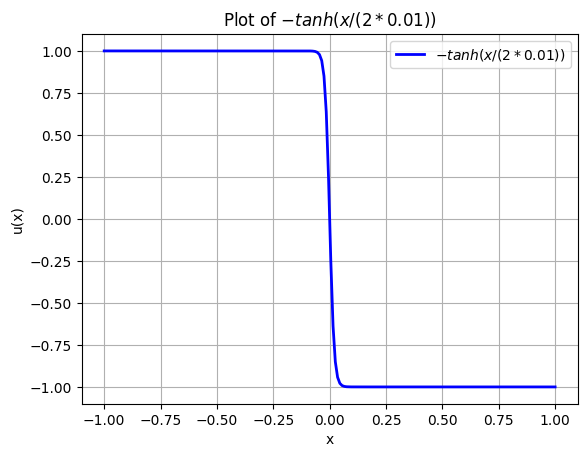

In [143]:
import numpy as np
import matplotlib.pyplot as plt

# Define the range of x
x = np.linspace(-1, 1, 200)  # 200 points between -1 and 1

# Compute -tanh(x/(2*0.01))
u_tanh01 = -np.tanh(x / (2*0.01))

# Plot the function -tanh(x/0.01)
plt.plot(x, u_tanh01, label=r'$-tanh(x/(2*0.01))$', color="blue", linewidth=2)
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title(r'Plot of $-tanh(x/(2*0.01))$')
plt.legend()
plt.grid(True)
plt.show()

# The function data is in the array u_tanh01


In [144]:
import numpy as np
import pandas as pd


# X_t[:, 0] contains the x values
# y_pred_t contains the predicted values from PINNs

# Create a DataFrame with the x values and PINNs predictions
data_pinns = pd.DataFrame({
    'x': X_t[:, 0],            # Column for the x values
    'u_pinns(x,t)': y_pred_t.flatten()  # Column for the PINNs predicted values
})

# Save the data to a CSV file
data_pinns.to_csv('pinns_data.csv', index=False)

print("Data saved to 'pinns_data.csv'")


Data saved to 'pinns_data.csv'


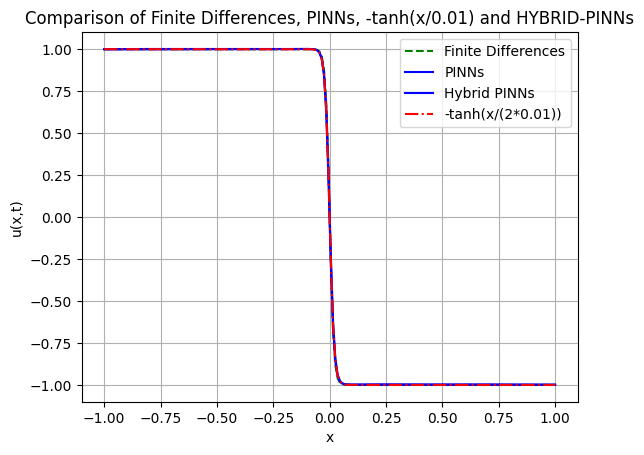

In [145]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV files
finite_differences_data = pd.read_csv('finite_differences_solution_t_0.5.csv')
pinns_data = pd.read_csv('pinns_solution_t_0.5.csv')
tanh_data = pd.read_csv('tanh_function_data.csv')
hybridpinns_data = pd.read_csv('hybrid_pinns_solution_t_0.5.csv')

# Plot the solutions
plt.figure()

# Plot the finite differences solution
plt.plot(finite_differences_data['x'], finite_differences_data['u(x,t=0.5)'], 'g--', label='Finite Differences')

# Plot the PINNs solution
plt.plot(pinns_data['x'], pinns_data['u_pinns(x,t=0.5)'], 'b-', label='PINNs')

# Plot the Hybrid PINNs solution
plt.plot(hybridpinns_data['x'], hybridpinns_data['u_hybridpinns(x,t=0.5)'], 'b-', label='Hybrid PINNs')

# Plot the analytical solution (-tanh(x/(2*0.1)))
plt.plot(tanh_data['x'], tanh_data['u(x)'], 'r-.', label='-tanh(x/(2*0.01))')

# Graph customization
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Comparison of Finite Differences, PINNs, -tanh(x/0.01) and HYBRID-PINNs')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


L^2 error for Finite Differences: 0.006069481143998049
L^2 error for PINNs: 0.0035789996633888883
L^2 error for Hybrid PINNs: 0.004018732017420284


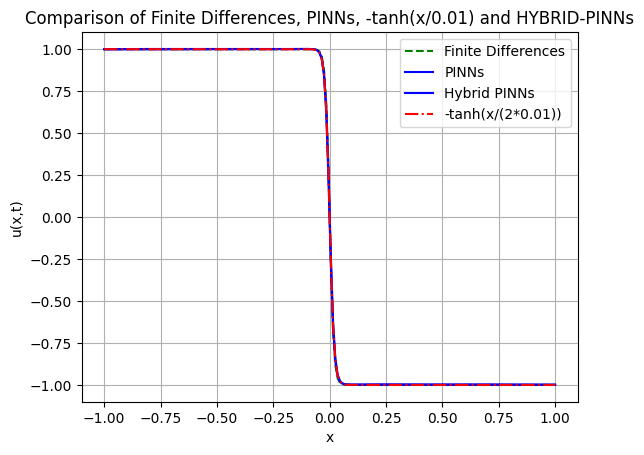

In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV files
finite_differences_data = pd.read_csv('finite_differences_solution_t_0.5.csv')
pinns_data = pd.read_csv('pinns_solution_t_0.5.csv')
tanh_data = pd.read_csv('tanh_function_data.csv')
hybridpinns_data = pd.read_csv('hybrid_pinns_solution_t_0.5.csv')

# Calculate the L^2 error between the numerical solution and the analytical solution
def calculate_L2_error(u_num, u_exact):
    N = len(u_num)  # Number of points
    return np.sqrt(np.sum((u_num - u_exact)**2) / N)

x_exact = tanh_data['x']
u_exact = tanh_data['u(x)']  # Analytical solution -tanh(x/(2*0.01))

# Extract the numerical solutions
u_fdm = finite_differences_data['u(x,t=0.5)']   # Finite Differences
u_pinns = pinns_data['u_pinns(x,t=0.5)']        # PINNs
u_hybrid_pinns = hybridpinns_data['u_hybridpinns(x,t=0.5)']  # Hybrid PINNs

# Calculate the L^2 errors
L2_error_fdm = calculate_L2_error(u_fdm, u_exact)
L2_error_pinns = calculate_L2_error(u_pinns, u_exact)
L2_error_hybrid_pinns = calculate_L2_error(u_hybrid_pinns, u_exact)

# Print the results
print(f"L^2 error for Finite Differences: {L2_error_fdm}")
print(f"L^2 error for PINNs: {L2_error_pinns}")
print(f"L^2 error for Hybrid PINNs: {L2_error_hybrid_pinns}")

# Plot the solutions
plt.figure()

# Plot the Finite Differences solution
plt.plot(finite_differences_data['x'], finite_differences_data['u(x,t=0.5)'], 'g--', label='Finite Differences')

# Plot the PINNs solution
plt.plot(pinns_data['x'], pinns_data['u_pinns(x,t=0.5)'], 'b-', label='PINNs')

# Plot the Hybrid PINNs solution
plt.plot(hybridpinns_data['x'], hybridpinns_data['u_hybridpinns(x,t=0.5)'], 'b-', label='Hybrid PINNs')

# Plot the analytical solution (-tanh(x/(2*0.01)))
plt.plot(tanh_data['x'], tanh_data['u(x)'], 'r-.', label='-tanh(x/(2*0.01))')

# Graph customization
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Comparison of Finite Differences, PINNs, -tanh(x/0.01) and HYBRID-PINNs')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


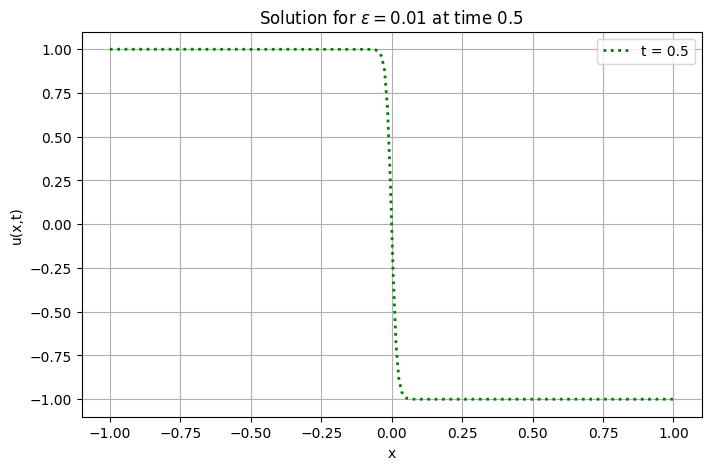

Data saved to 'finite_differences_solution_t_0.5.csv'


In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
epsilon = 0.0101  # Viscosity parameter
L = 2          # Length of the domain [-1, 1]
N = 200        # Number of points in space
dt = 0.0001    # Time step
T = 3          # Maximum time
x = np.linspace(-1, 1, N)  # Spatial grid

# Initial condition u(x,0) = -tanh(x/0.1)
u = -np.tanh(x / (2*0.01))

# Initialize the list of solutions
solutions = [u.copy()]

# Function to solve the Burgers' equation using finite differences
def solve_burgers(u, dt, epsilon, T):
    dx = x[1] - x[0]
    Nt = int(T / dt)

    for n in range(Nt):
        u_new = u.copy()
        for i in range(1, N-1):
            du_x = (u[i+1] - u[i-1]) / (2 * dx)
            du_xx = (u[i+1] - 2 * u[i] + u[i-1]) / dx**2
            u_new[i] = u[i] + dt * (-u[i] * du_x + epsilon * du_xx)

        # Apply boundary conditions
        u_new[0] = np.tanh(1 / (2*0.1))
        u_new[-1] = -np.tanh(1 / (2*0.1))
        u = u_new

        # Store the solutions at t = 0, 0.25, 0.5
        if n * dt in [0, 0.25, 0.5]:
            solutions.append(u.copy())

    return u

# Solve the Burgers' equation
solve_burgers(u, dt, epsilon, T)

# Plot the results at t = 0.5
plt.figure(figsize=(8, 5))
plt.plot(x, solutions[2], 'g:', label='t = 0.5', linewidth=2)
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Solution for $\\epsilon = 0.01$ at time 0.5')
plt.legend()
plt.grid(True)
plt.show()

# Save the data to a CSV file
# Create a DataFrame with the values of x and u at t = 0.5
data_fd = pd.DataFrame({
    'x': x,           # Column for the x values
    'u(x,t=0.5)': solutions[2]  # Column for the values of u(x,t=0.5)
})

# Save the data to a CSV file
data_fd.to_csv('finite_differences_solution_t_0.5.csv', index=False)

print("Data saved to 'finite_differences_solution_t_0.5.csv'")


Compiling model...
Building feed-forward neural network...
'build' took 0.148613 s

'compile' took 12.366254 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.12e-02, 3.73e-01, 4.00e-01, 6.24e-01]    [1.12e-02, 3.73e-01, 4.00e-01, 6.24e-01]    []  
1000      [5.86e-04, 8.08e-06, 1.56e-05, 3.55e-05]    [5.86e-04, 8.08e-06, 1.56e-05, 3.55e-05]    []  
2000      [7.62e-05, 3.22e-07, 8.79e-07, 6.90e-07]    [7.62e-05, 3.22e-07, 8.79e-07, 6.90e-07]    []  
3000      [9.61e-05, 3.81e-08, 6.62e-07, 1.33e-06]    [9.61e-05, 3.81e-08, 6.62e-07, 1.33e-06]    []  
4000      [5.04e-05, 4.19e-08, 9.09e-08, 1.13e-06]    [5.04e-05, 4.19e-08, 9.09e-08, 1.13e-06]    []  
5000      [1.37e-05, 6.23e-08, 5.47e-08, 6.77e-07]    [1.37e-05, 6.23e-08, 5.47e-08, 6.77e-07]    []  

Best model at step 5000:
  train loss: 1.45e-05
  test loss: 1.45e-05
  test metric: []

'train' took 61.858134 s

Data saved to 'pinns_solu

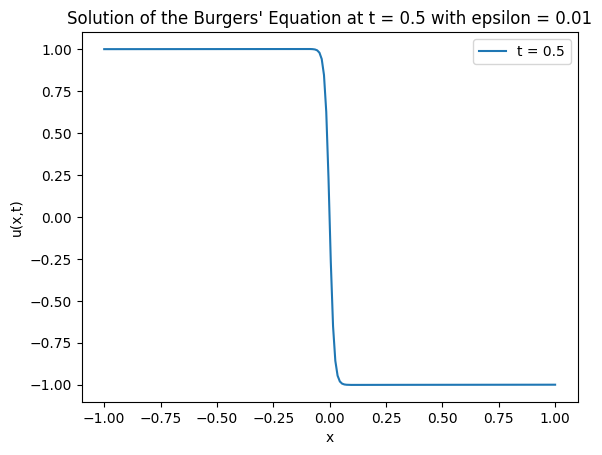

In [148]:
import deepxde as dde
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Viscosity parameter
epsilon = 0.01  # Viscosity

# Define the Burgers' equation with viscosity
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Define the spatial and temporal boundaries
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Adjusted boundary conditions
bc_left = dde.DirichletBC(geomtime, lambda x: np.array([1]), on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: np.array([-1]), on_boundary=lambda x, _: np.isclose(x[0], 1))

# Adjusted initial condition u(x,0)
ic = dde.IC(geomtime, lambda x: -np.tanh(x[:, 0:1] / (2*0.01)), lambda _, on_initial: on_initial)

# Define the problem
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=400, num_boundary=40, num_initial=40)

# Define the neural network
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# The model
model = dde.Model(data, net)

# Train the model
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=5000)

# Generate points to predict at t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), 0.5 * np.ones((200, 1))))
y_pred_t = model.predict(X_t)

# Save the data to a CSV file
data_pinns = pd.DataFrame({
    'x': X_t[:, 0],            # Column for the x values
    'u_pinns(x,t=0.5)': y_pred_t.flatten()  # Column for the PINNs predictions
})

# Save the data to a CSV file
data_pinns.to_csv('pinns_solution_t_0.5.csv', index=False)

print("Data saved to 'pinns_solution_t_0.5.csv'")

# Visualization: Solution at t = 0.5
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label="t = 0.5")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("Solution of the Burgers' Equation at t = 0.5 with epsilon = 0.01")
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.145957 s

'compile' took 6.786096 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.18e-02, 3.73e-01, 4.08e-01, 6.24e-01]    [1.18e-02, 3.73e-01, 4.08e-01, 6.24e-01]    []  
1000      [4.83e-04, 2.02e-05, 1.63e-05, 3.47e-05]    [4.83e-04, 2.02e-05, 1.63e-05, 3.47e-05]    []  
2000      [6.69e-05, 2.80e-07, 6.51e-07, 7.79e-07]    [6.69e-05, 2.80e-07, 6.51e-07, 7.79e-07]    []  
3000      [1.53e-04, 2.80e-05, 2.21e-05, 1.85e-05]    [1.53e-04, 2.80e-05, 2.21e-05, 1.85e-05]    []  
4000      [1.66e-05, 5.00e-08, 1.15e-07, 4.59e-07]    [1.66e-05, 5.00e-08, 1.15e-07, 4.59e-07]    []  
5000      [2.60e-05, 2.07e-07, 2.94e-07, 1.20e-06]    [2.60e-05, 2.07e-07, 2.94e-07, 1.20e-06]    []  

Best model at step 4000:
  train loss: 1.73e-05
  test loss: 1.73e-05
  test metric: []

'train' took 74.309902 s

Data saved to 'hybrid_pinn

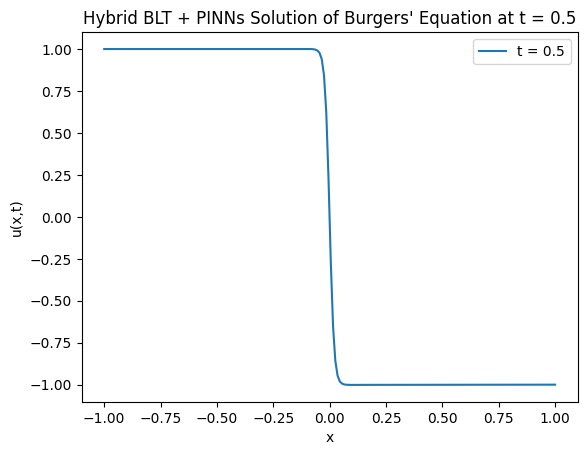

In [149]:
import deepxde as dde
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Viscosity parameter
epsilon = 0.01  # Viscosity

# Approximation of the solution based on BLT (Boundary Layer Theory)
def blt_boundary_layer_solution(x, epsilon):
    # Approximation near x = 0 where the sharp transition occurs
    return -np.tanh(x / (2 * epsilon))

# Define the Burgers' equation with viscosity
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Define the spatial and temporal boundaries
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Hybrid: Initial condition using BLT near x = 0
def hybrid_blt_ic(x):
    # Initial condition based on BLT, centered around the transition at x = 0
    return np.array([blt_boundary_layer_solution(xi[0], epsilon) for xi in x]).reshape(-1, 1)

# Boundary conditions
bc_left = dde.DirichletBC(geomtime, lambda x: np.array([1]), on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: np.array([-1]), on_boundary=lambda x, _: np.isclose(x[0], 1))

# Set the initial condition u(x,0) using the BLT approach
ic = dde.IC(geomtime, hybrid_blt_ic, lambda _, on_initial: on_initial)

# Define the problem using the hybrid approach (BLT + PINNs)
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=400, num_boundary=40, num_initial=40)

# Define the neural network
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# The hybrid model (BLT + PINNs)
model = dde.Model(data, net)

# Train the model
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=5000)

# Generate points to predict at t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), 0.5 * np.ones((200, 1))))
y_pred_t = model.predict(X_t)

# Save the data to a CSV file
data_pinns = pd.DataFrame({
    'x': X_t[:, 0],            # Column for the x values
    'u_hybridpinns(x,t=0.5)': y_pred_t.flatten()  # Column for the PINNs predictions
})

# Save the data to a CSV file
data_pinns.to_csv('hybrid_pinns_solution_t_0.5.csv', index=False)

print("Data saved to 'hybrid_pinns_solution_t_0.5.csv'")

# Visualization: Solution at t = 0.5
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label="t = 0.5")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("Hybrid BLT + PINNs Solution of Burgers' Equation at t = 0.5")
plt.show()


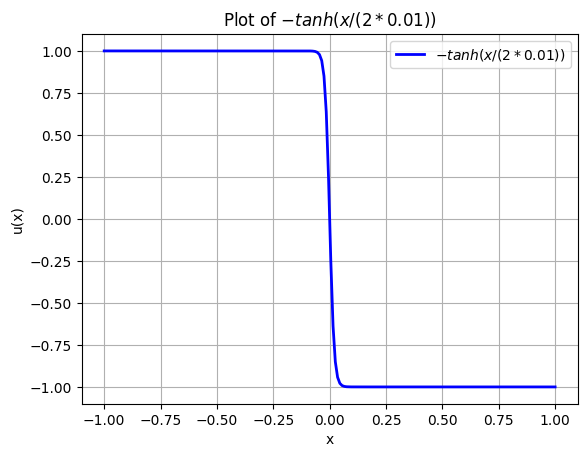

'tanh_function_data.csv'

In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the range of x
x = np.linspace(-1, 1, 200)  # 200 points between -1 and 1

# Compute -tanh(x/(2*0.01))
u_tanh01 = -np.tanh(x / (2*0.01))

# Plot the function -tanh(x/0.01)
plt.plot(x, u_tanh01, label=r'$-tanh(x/(2*0.01))$', color="blue", linewidth=2)
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title(r'Plot of $-tanh(x/(2*0.01))$')
plt.legend()
plt.grid(True)
plt.show()

# Create a DataFrame with the values of x and u_tanh01
data_tanh = pd.DataFrame({
    'x': x,           # Column for x values
    'u(x)': u_tanh01  # Column for the values of -tanh(x/(2*0.01))
})

# Save the data
file_path_tanh = 'tanh_function_data.csv'
data_tanh.to_csv(file_path_tanh, index=False)

file_path_tanh


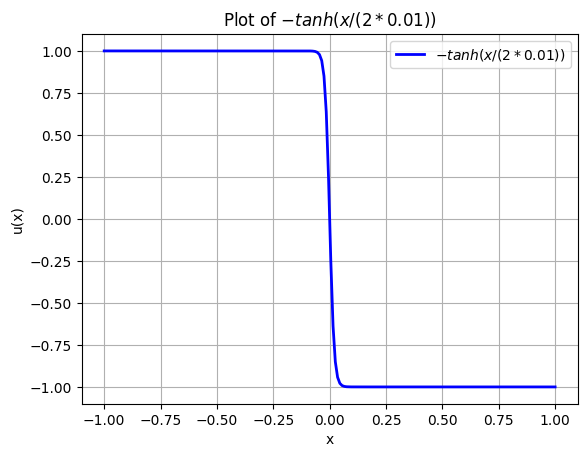

'tanh_function_data.csv'

In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the range of x
x = np.linspace(-1, 1, 200)  # 200 points between -1 and 1

# Compute -tanh(x/(2*0.01))
u_tanh01 = -np.tanh(x / (2*0.01))

# Plot the function -tanh(x/0.01)
plt.plot(x, u_tanh01, label=r'$-tanh(x/(2*0.01))$', color="blue", linewidth=2)
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title(r'Plot of $-tanh(x/(2*0.01))$')
plt.legend()
plt.grid(True)
plt.show()

# Create a DataFrame with the values of x and u_tanh01
data_tanh = pd.DataFrame({
    'x': x,           # Column for x values
    'u(x)': u_tanh01  # Column for the values of -tanh(x/(2*0.01))
})

# Save the data
file_path_tanh = 'tanh_function_data.csv'
data_tanh.to_csv(file_path_tanh, index=False)

file_path_tanh


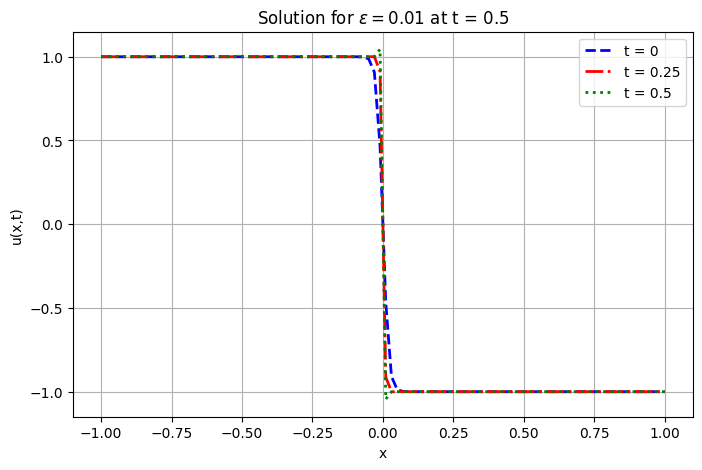

In [152]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
epsilon = 0.01  # Viscosity parameter
L = 2           # Length of the domain [-1, 1]
N = 100         # Number of points in space
dt = 1e-3       # Reduced time step for stability
T = 0.56        # Maximum time reduced to 0.5 to avoid large errors
x = np.linspace(-1, 1, N)  # Spatial grid

# Initial condition u(x,0) = -tanh(x/0.1)
u = -np.tanh(x / (2 * 0.01))

# Initialize the array of solutions
solutions = [u.copy()]

# Function to compute the numerical solution using explicit finite differences
def solve_burgers(u, dt, epsilon, T):
    dx = x[1] - x[0]
    Nt = int(T / dt)

    for n in range(Nt):
        u_new = u.copy()
        for i in range(1, N-1):
            du_x = (u[i+1] - u[i-1]) / (2 * dx)
            du_xx = (u[i+1] - 2 * u[i] + u[i-1]) / dx**2
            u_new[i] = u[i] + dt * (-u[i] * du_x + epsilon * du_xx)

        # Apply boundary conditions consistent with the physical solution
        u_new[0] = np.tanh(1 / (2 * 0.01))
        u_new[-1] = -np.tanh(1 / (2 * 0.01))
        u = u_new

        # Save solutions at specific times
        if np.isclose(n * dt, 0.25) or np.isclose(n * dt, 0.5):
            solutions.append(u.copy())

    return u

# Solve the Burgers' equation
solve_burgers(u, dt, epsilon, T)

# Plot the results at t = 0.5
plt.figure(figsize=(8, 5))
plt.plot(x, solutions[0], 'b--', label='t = 0', linewidth=2)
plt.plot(x, solutions[1], 'r-.', label='t = 0.25', linewidth=2)
plt.plot(x, solutions[2], 'g:', label='t = 0.5', linewidth=2)
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Solution for $\epsilon = 0.01$ at t = 0.5')
plt.legend()
plt.grid(True)
plt.show()


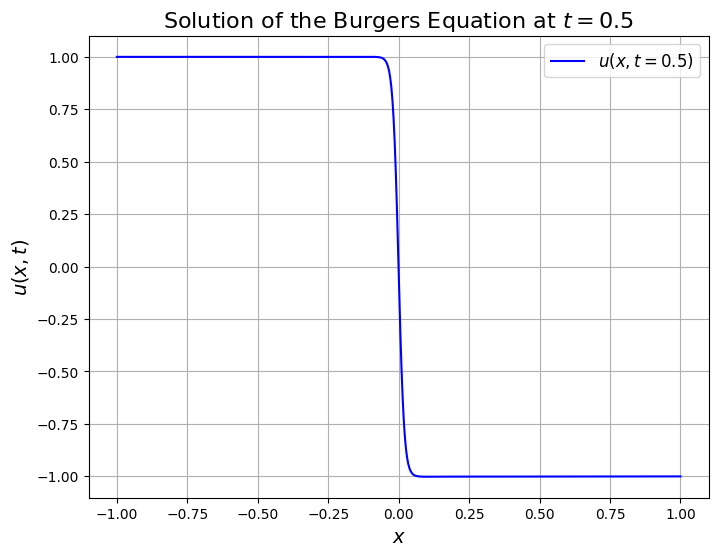

In [153]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

# Generate x values in the domain [-1, 1]
x_vals = np.linspace(-1, 1, 500).reshape(-1, 1)
t_fixed = 0.5 * np.ones_like(x_vals)

# Create the input set for prediction
X_input = np.hstack((x_vals, t_fixed))

# Predict u(x, t=0.5)
u_pred = model.predict(X_input)

# Plot u(x, t=0.5)
plt.figure(figsize=(8, 6))
plt.plot(x_vals, u_pred, label=r'$u(x, t=0.5)$', color='blue')
plt.xlabel(r'$x$', fontsize=14)
plt.ylabel(r'$u(x, t)$', fontsize=14)
plt.title(r'Solution of the Burgers Equation at $t=0.5$', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# Save the figure with high resolution for publication
plt.savefig('burgers_solution_t_0.5.png', dpi=300, bbox_inches='tight')
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.127069 s

'compile' took 4.280759 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.01e-02, 3.73e-01, 4.05e-01, 4.66e-01]    [1.01e-02, 3.73e-01, 4.05e-01, 4.66e-01]    []  
1000      [5.66e-05, 1.89e-07, 2.13e-06, 1.05e-06]    [5.66e-05, 1.89e-07, 2.13e-06, 1.05e-06]    []  
2000      [2.06e-05, 5.44e-08, 1.73e-07, 1.08e-06]    [2.06e-05, 5.44e-08, 1.73e-07, 1.08e-06]    []  
3000      [1.18e-05, 3.30e-06, 4.69e-06, 4.27e-06]    [1.18e-05, 3.30e-06, 4.69e-06, 4.27e-06]    []  
4000      [3.68e-05, 2.34e-05, 3.95e-05, 1.29e-05]    [3.68e-05, 2.34e-05, 3.95e-05, 1.29e-05]    []  
5000      [3.60e-06, 2.35e-08, 2.72e-07, 3.84e-07]    [3.60e-06, 2.35e-08, 2.72e-07, 3.84e-07]    []  

Best model at step 5000:
  train loss: 4.28e-06
  test loss: 4.28e-06
  test metric: []

'train' took 52.628017 s



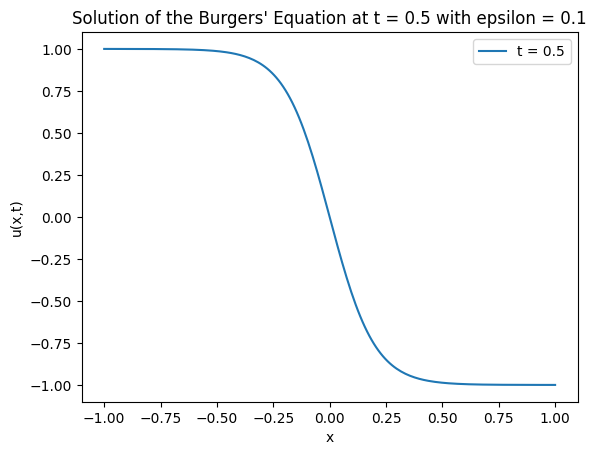

In [98]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

# Parameter for the equation
epsilon = 0.1  # Viscosity

# Approximation for boundary layers using BLT
def blt_boundary_layer_solution(x, epsilon):
    # BLT approximation near the boundaries
    if np.isclose(x, -1):
        return 1
    elif np.isclose(x, 1):
        return -1
    else:
        # Outside the boundary layer, return a neutral value
        return -np.tanh(x / (2 * epsilon))

# Define the Burgers' equation with viscosity for PINNs
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Define the spatial and temporal domain limits
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Hybrid boundary condition using BLT approximation near boundaries
def hybrid_blt_bc(x, on_boundary):
    if on_boundary:
        return np.array([blt_boundary_layer_solution(x[0], epsilon)])
    return None

# Adjusted boundary conditions using the hybrid approach
bc_left = dde.DirichletBC(geomtime, lambda x: np.array([blt_boundary_layer_solution(-1, epsilon)]),
                          on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: np.array([blt_boundary_layer_solution(1, epsilon)]),
                           on_boundary=lambda x, _: np.isclose(x[0], 1))

# Adjusted initial condition u(x,0)
ic = dde.IC(geomtime, lambda x: -np.tanh(x[:, 0:1] / (2 * 0.1)), lambda _, on_initial: on_initial)

# Define the problem
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=400, num_boundary=40, num_initial=40)

# Define the neural network (PINNs part)
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# The model
model = dde.Model(data, net)

# Train the model
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=5000)

# Generate points to predict at t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), 0.5 * np.ones((200, 1))))
y_pred_t = model.predict(X_t)

# Visualization: Solution at t = 0.5
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label="t = 0.5")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("Solution of the Burgers' Equation at t = 0.5 with epsilon = 0.1")
plt.show()


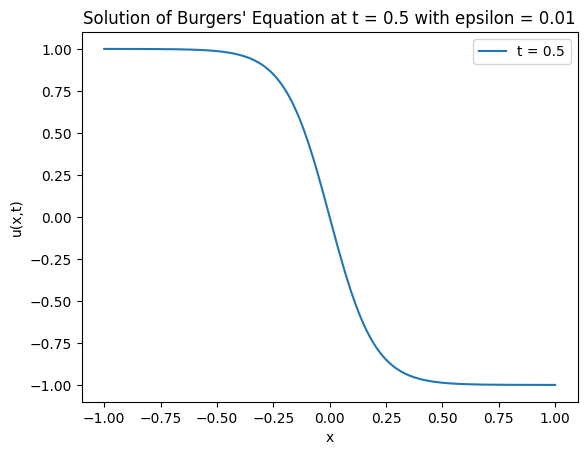

In [99]:
# Visualization: Solution at t = 0.5
t = 0.5  # Define the time t at which we want the solution
plt.figure()
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), t * np.ones((200, 1))))
y_pred_t = model.predict(X_t)
plt.plot(X_t[:, 0], y_pred_t, label=f"t = {t}")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title(f"Solution of Burgers' Equation at t = {t} with epsilon = 0.01")
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.110929 s

'compile' took 5.758744 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.16e-02, 3.73e-01, 4.00e-01, 6.24e-01]    [1.16e-02, 3.73e-01, 4.00e-01, 6.24e-01]    []  
1000      [5.66e-04, 3.84e-05, 2.54e-05, 2.80e-05]    [5.66e-04, 3.84e-05, 2.54e-05, 2.80e-05]    []  
2000      [2.44e-04, 2.69e-05, 1.75e-05, 1.35e-05]    [2.44e-04, 2.69e-05, 1.75e-05, 1.35e-05]    []  
3000      [4.77e-04, 4.65e-07, 7.83e-07, 3.73e-06]    [4.77e-04, 4.65e-07, 7.83e-07, 3.73e-06]    []  
4000      [2.02e-05, 6.76e-08, 1.72e-07, 3.52e-07]    [2.02e-05, 6.76e-08, 1.72e-07, 3.52e-07]    []  
5000      [1.95e-05, 7.10e-08, 4.59e-08, 5.09e-07]    [1.95e-05, 7.10e-08, 4.59e-08, 5.09e-07]    []  

Best model at step 5000:
  train loss: 2.01e-05
  test loss: 2.01e-05
  test metric: []

'train' took 87.453513 s



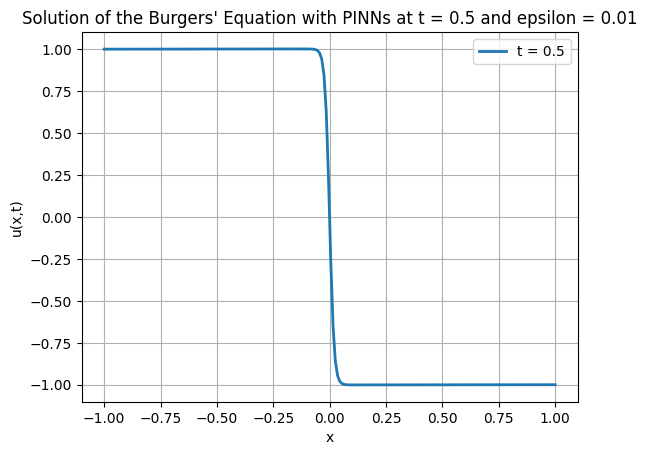

In [154]:
import deepxde as dde
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Define parameters
epsilon = 0.01  # Small viscosity to observe the boundary layer

# Define the Burgers' equation with viscosity
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # Partial derivative u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # Partial derivative u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # Second derivative u_xx
    return u_t + u * u_x - epsilon * u_xx

# Define the geometry of the problem (spatial interval and time domain)
geom = dde.geometry.Interval(-1, 1)  # Spatial domain [-1, 1]
timedomain = dde.geometry.TimeDomain(0, 1)  # Time domain [0, 1]
geomtime = dde.geometry.GeometryXTime(geom, timedomain)  # Space and time domain

# Boundary conditions at x=-1 and x=1
bc_left = dde.DirichletBC(geomtime, lambda x: np.array([1]), on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: np.array([-1]), on_boundary=lambda x, _: np.isclose(x[0], 1))

# Initial condition u(x,0) = -tanh(x / (2*epsilon))
ic = dde.IC(geomtime, lambda x: -np.tanh(x[:, 0:1] / (2 * epsilon)), lambda _, on_initial: on_initial)

# Define the problem with PINNs
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=400, num_boundary=40, num_initial=40)

# Define the neural network to approximate the solution
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# Define the PINNs model
model = dde.Model(data, net)

# Train the model
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=5000)

# Generate prediction points at t=0.5 to observe the solution in the boundary layer
t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), t * np.ones((200, 1))))
y_pred_t = model.predict(X_t)

# Plot the solution at t=0.5
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label=f"t = {t}", linewidth=2)
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title(f"Solution of the Burgers' Equation with PINNs at t = {t} and epsilon = {epsilon}")
plt.legend()
plt.grid(True)
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.079632 s

'compile' took 2.095197 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.03e-02, 3.73e-01, 4.02e-01, 5.52e-01]    [1.03e-02, 3.73e-01, 4.02e-01, 5.52e-01]    []  
1000      [5.64e-04, 2.84e-05, 6.31e-05, 3.71e-03]    [5.64e-04, 2.84e-05, 6.31e-05, 3.71e-03]    []  
2000      [3.93e-04, 3.35e-05, 5.28e-05, 2.10e-03]    [3.93e-04, 3.35e-05, 5.28e-05, 2.10e-03]    []  
3000      [2.33e-04, 9.48e-06, 4.12e-06, 1.06e-03]    [2.33e-04, 9.48e-06, 4.12e-06, 1.06e-03]    []  
4000      [1.27e-04, 1.04e-05, 2.70e-06, 6.38e-04]    [1.27e-04, 1.04e-05, 2.70e-06, 6.38e-04]    []  
5000      [2.65e-04, 1.26e-04, 7.08e-05, 4.02e-04]    [2.65e-04, 1.26e-04, 7.08e-05, 4.02e-04]    []  

Best model at step 4000:
  train loss: 7.78e-04
  test loss: 7.78e-04
  test metric: []

'train' took 51.577262 s



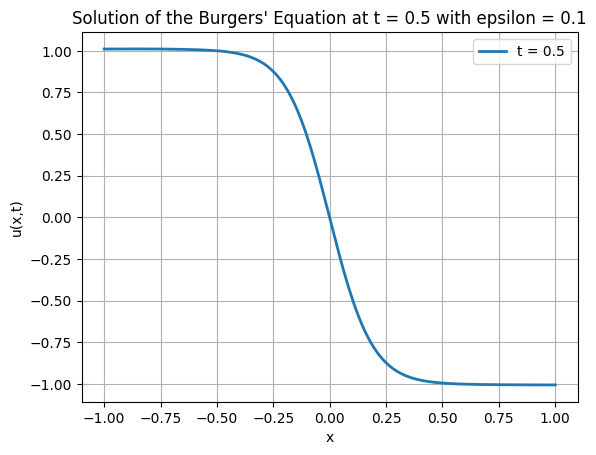

In [101]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

# Parameter for the equation
epsilon = 0.1  # Viscosity

# Define the Burgers' equation with viscosity
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Define the spatial and temporal domain limits
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Define the adjusted boundary conditions
bc_left = dde.DirichletBC(geomtime, lambda x: np.array([1]), on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: np.array([-1]), on_boundary=lambda x, _: np.isclose(x[0], 1))

# Adjusted initial condition u(x,0)
ic = dde.IC(geomtime, lambda x: -np.tanh(x[:, 0:1] / 0.1), lambda _, on_initial: on_initial)

# Define the problem
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=400, num_boundary=40, num_initial=40)

# Define the neural network
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# The model
model = dde.Model(data, net)

# Train the model
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=5000)

# Generate points to predict at t=0.5
t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), t * np.ones((200, 1))))
y_pred_t = model.predict(X_t)

# Plot the solution at t=0.5
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label=f"t = {t}", linewidth=2)
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title(f"Solution of the Burgers' Equation at t = {t} with epsilon = {epsilon}")
plt.legend()
plt.grid(True)
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.203282 s

'compile' took 2.297651 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.15e-02, 3.73e-01, 4.00e-01, 6.28e-01]    [1.15e-02, 3.73e-01, 4.00e-01, 6.28e-01]    []  
1000      [4.83e-04, 7.51e-06, 1.17e-05, 2.18e-04]    [4.83e-04, 7.51e-06, 1.17e-05, 2.18e-04]    []  
2000      [7.24e-05, 2.80e-07, 2.43e-07, 1.47e-04]    [7.24e-05, 2.80e-07, 2.43e-07, 1.47e-04]    []  
3000      [2.08e-03, 2.08e-06, 5.40e-06, 1.53e-04]    [2.08e-03, 2.08e-06, 5.40e-06, 1.53e-04]    []  
4000      [2.46e-05, 9.38e-07, 7.14e-07, 1.44e-04]    [2.46e-05, 9.38e-07, 7.14e-07, 1.44e-04]    []  
5000      [2.32e-05, 2.68e-07, 1.09e-06, 1.47e-04]    [2.32e-05, 2.68e-07, 1.09e-06, 1.47e-04]    []  

Best model at step 4000:
  train loss: 1.70e-04
  test loss: 1.70e-04
  test metric: []

'train' took 51.702105 s



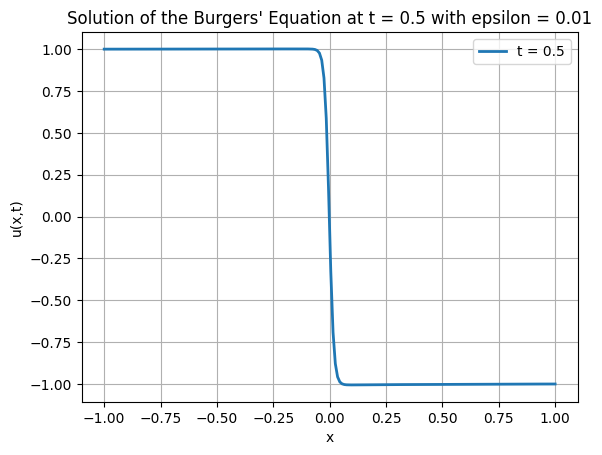

In [102]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

# Parameter for the equation
epsilon = 0.01  # Viscosity

# Define the Burgers' equation with viscosity
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Define the spatial and temporal domain limits
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Define the adjusted boundary conditions
bc_left = dde.DirichletBC(geomtime, lambda x: np.array([1]), on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: np.array([-1]), on_boundary=lambda x, _: np.isclose(x[0], 1))

# Adjusted initial condition u(x,0)
ic = dde.IC(geomtime, lambda x: -np.tanh(x[:, 0:1] / 0.01), lambda _, on_initial: on_initial)

# Define the problem
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=400, num_boundary=40, num_initial=40)

# Define the neural network
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# The model
model = dde.Model(data, net)

# Train the model
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=5000)

# Generate points to predict at t=0.5
t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), t * np.ones((200, 1))))
y_pred_t = model.predict(X_t)

# Plot the solution at t=0.5
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label=f"t = {t}", linewidth=2)
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title(f"Solution of the Burgers' Equation at t = {t} with epsilon = {epsilon}")
plt.legend()
plt.grid(True)
plt.show()


In [155]:
import numpy as np
import pandas as pd

# Create a DataFrame with the values of x and the predictions y_pred_t
data_pinns = pd.DataFrame({
    'x': X_t[:, 0],   # Column for the x values
    'u(x,t)': y_pred_t.flatten()  # Column for the predicted values of u(x,t)
})

# Save the data to a CSV file
data_pinns.to_csv('pinns_data01.csv', index=False)

print("Data saved to 'pinns_data.csv'")


Data saved to 'pinns_data.csv'


Compiling model...
Building feed-forward neural network...
'build' took 0.133372 s

'compile' took 6.537339 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.01e-02, 3.73e-01, 3.99e-01, 4.66e-01]    [1.01e-02, 3.73e-01, 3.99e-01, 4.66e-01]    []  
1000      [5.67e-05, 3.08e-07, 4.04e-06, 1.40e-06]    [5.67e-05, 3.08e-07, 4.04e-06, 1.40e-06]    []  
2000      [2.81e-05, 4.65e-06, 9.24e-06, 7.01e-06]    [2.81e-05, 4.65e-06, 9.24e-06, 7.01e-06]    []  
3000      [1.17e-05, 5.34e-06, 5.26e-06, 1.90e-06]    [1.17e-05, 5.34e-06, 5.26e-06, 1.90e-06]    []  
4000      [1.02e-05, 7.21e-06, 6.20e-06, 5.43e-06]    [1.02e-05, 7.21e-06, 6.20e-06, 5.43e-06]    []  
5000      [2.05e-05, 1.98e-05, 1.89e-05, 7.76e-06]    [2.05e-05, 1.98e-05, 1.89e-05, 7.76e-06]    []  

Best model at step 3000:
  train loss: 2.42e-05
  test loss: 2.42e-05
  test metric: []

'train' took 78.961530 s



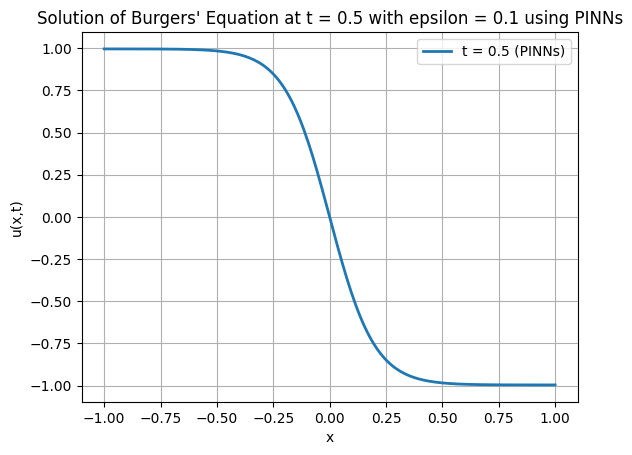

In [156]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

# Parameter for the equation
epsilon = 0.1  # Viscosity

# Define the Burgers' equation with viscosity
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Define the spatial and temporal limits
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Define adjusted boundary conditions
bc_left = dde.DirichletBC(geomtime, lambda x: np.array([1]), on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: np.array([-1]), on_boundary=lambda x, _: np.isclose(x[0], 1))

# Adjusted initial condition u(x,0)
ic = dde.IC(geomtime, lambda x: -np.tanh(x[:, 0:1] / (2*0.1)), lambda _, on_initial: on_initial)

# Define the problem
data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=400, num_boundary=40, num_initial=40)

# Define the neural network
net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

# The model
model = dde.Model(data, net)

# Train the model
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=5000)

# Get predictions at t=0.5
t = 0.5
X_t = np.hstack((np.linspace(-1, 1, 200).reshape(-1, 1), t * np.ones((200, 1))))
y_pred_t = model.predict(X_t)  # These are the PINNs predictions at t=0.5

# Plot the solution at t=0.5
plt.figure()
plt.plot(X_t[:, 0], y_pred_t, label=f"t = {t} (PINNs)", linewidth=2)
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title(f"Solution of Burgers' Equation at t = {t} with epsilon = {epsilon} using PINNs")
plt.legend()
plt.grid(True)
plt.show()


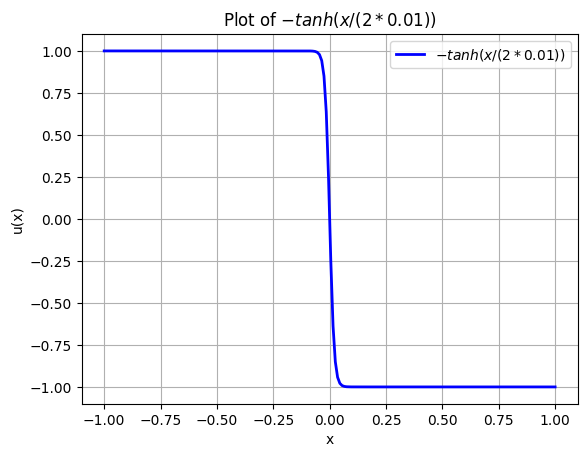

In [157]:
import numpy as np
import matplotlib.pyplot as plt

# Define the x interval
x = np.linspace(-1, 1, 200)

# Calculate the function -tanh(x/0.1)
y = -np.tanh(x / (2*0.01))

# Plot the graph
plt.plot(x, y, label=r'$-tanh(x/(2*0.01))$', color='b', linewidth=2)

# Add labels and title
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('Plot of $-tanh(x/(2*0.01))$')

# Show the legend and the graph
plt.legend()
plt.grid(True)
plt.show()


In [158]:
import numpy as np
import pandas as pd

# Define the range of x
x = np.linspace(-1, 1, 200)  # 200 points between -1 and 1

# Calculate -tanh(x/0.01)
u_tanh01 = -np.tanh(x /(2*0.01))

# Create a DataFrame with the values of x and u(x)
data = pd.DataFrame({
    'x': x,
    'u(x)': u_tanh01
})

# Save the data to a CSV file
data.to_csv('tanh_data01.csv', index=False)

print("Data saved in 'tanh_data01.csv'")


Data saved in 'tanh_data01.csv'


In [159]:
import numpy as np
import pandas as pd

# Create a DataFrame with the values of x and the predictions y_pred_t
data_pinns = pd.DataFrame({
    'x': X_t[:, 0],   # Column for the x values
    'u(x,t)': y_pred_t.flatten()  # Column for the predicted values of u(x,t)
})

# Save the data to a CSV file
data_pinns.to_csv('pinns_data.csv', index=False)

print("Data saved in 'pinns_data.csv'")


Data saved in 'pinns_data.csv'


In [160]:
import numpy as np
import pandas as pd

# Define the range of x
x = np.linspace(-1, 1, 200)  # 200 points between -1 and 1

# Calculate -tanh(x/0.1)
u_tanh = -np.tanh(x / 0.1)

# Create a DataFrame with the values of x and u(x)
data = pd.DataFrame({
    'x': x,
    'u(x)': u_tanh
})

# Save the data to a CSV file
data.to_csv('tanh_data.csv', index=False)

print("Data saved in 'tanh_data.csv'")


Data saved in 'tanh_data.csv'


In [161]:
import numpy as np
import pandas as pd

# Create a DataFrame with the values of x and the predictions y_pred_t
data_pinns = pd.DataFrame({
    'x': X_t[:, 0],   # Column for the x values
    'u(x,t)': y_pred_t.flatten()  # Column for the predicted values of u(x,t)
})

# Save the data to a CSV file
data_pinns.to_csv('pinns_data.csv', index=False)

print("Data saved in 'pinns_data.csv'")


Data saved in 'pinns_data.csv'


In [162]:
import numpy as np
import pandas as pd

# Define the BLT solution for comparison (using the same boundary layer approximation)
def blt_boundary_layer_solution(x, epsilon):
    return -np.tanh(x / (2*epsilon))

epsilon = 0.01  # Viscosity parameter


# X_t[:, 0] contains the x values
# y_pred_t contains the predicted values from PINNs

# Compute the BLT solution at the same x points
blt_solution = blt_boundary_layer_solution(X_t[:, 0], epsilon)

# Create a DataFrame with the x values, BLT solution, and PINNs predictions
data_combined = pd.DataFrame({
    'x': X_t[:, 0],            # Column for the x values
    'u_blt(x)': blt_solution,   # Column for the BLT solution
    'u_pinns(x,t)': y_pred_t.flatten()  # Column for the PINNs predicted values
})

# Save the data to a CSV file
data_combined.to_csv('blt_pinns_data.csv', index=False)

print("Data saved to 'blt_pinns_data.csv'")


Data saved to 'blt_pinns_data.csv'


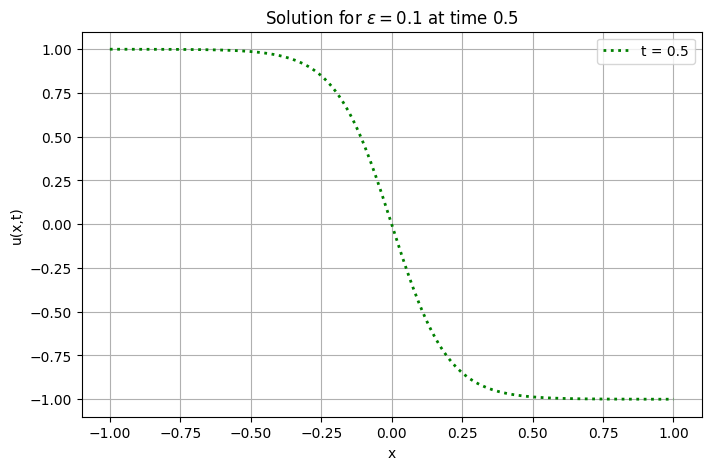

In [163]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
epsilon = 0.1  # Viscosity parameter
L = 2          # Length of the domain [-1, 1]
N = 200        # Number of points in space
dt = 0.0001     # Time step
T = 3          # Maximum time
x = np.linspace(-1, 1, N)  # Space grid

# Initial condition u(x,0) = -tanh(x/0.1)
u = -np.tanh(x / (2*0.1))

# Initialize the solution array
solutions = [u.copy()]

# Function to compute the numerical solution using finite differences
def solve_burgers(u, dt, epsilon, T):
    dx = x[1] - x[0]
    Nt = int(T / dt)

    for n in range(Nt):
        u_new = u.copy()
        for i in range(1, N-1):
            du_x = (u[i+1] - u[i-1]) / (2 * dx)
            du_xx = (u[i+1] - 2 * u[i] + u[i-1]) / dx**2
            u_new[i] = u[i] + dt * (-u[i] * du_x + epsilon * du_xx)

        # Apply boundary conditions
        u_new[0] = np.tanh(1 / (2*0.1))
        u_new[-1] = -np.tanh(1 / (2*0.1))
        u = u_new

        # Store solutions at t = 0, 0.25, and 0.5
        if n * dt in [0, 0.25, 0.5]:
            solutions.append(u.copy())

    return u

# Solve the Burgers' equation
solve_burgers(u, dt, epsilon, T)

# Crear un DataFrame con los valores de x y las soluciones en t = 0.5
data_finite_differences = pd.DataFrame({
    'x': x,           # Columna para los valores de x
    'u(x,t)': solutions[2]  # Columna para los valores de u(x,t)
})

# Guardar los datos en un archivo CSV con 200 puntos
file_path_finite_differences = 'finite_differences_data.csv'
data_finite_differences.to_csv(file_path_finite_differences, index=False)

# Visualizar todos los resultados en t = 0.5 con los 200 datos de la malla espacial
plt.figure(figsize=(8, 5))
plt.plot(x, solutions[2], 'g:', label='t = 0.5', linewidth=2)
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Solution for $\epsilon = 0.1$ at time 0.5')
plt.legend()
plt.grid(True)
plt.show()



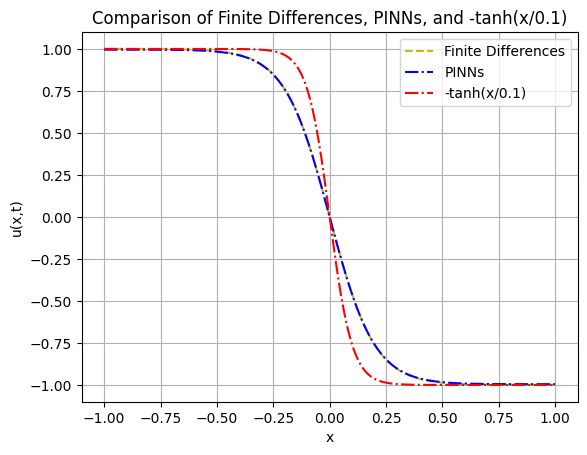

In [164]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV files
finite_differences_data = pd.read_csv('finite_differences_data.csv')
pinns_data = pd.read_csv('pinns_data.csv')
tanh_data = pd.read_csv('tanh_data.csv')

# Plot the solutions
plt.figure()

# Plot the finite differences solution
plt.plot(finite_differences_data['x'], finite_differences_data['u(x,t)'], 'y--', label='Finite Differences')

# Plot the PINNs solution
plt.plot(pinns_data['x'], pinns_data['u(x,t)'], 'b-.', label='PINNs')

# Plot the analytical solution (-tanh(x/0.1))
plt.plot(tanh_data['x'], tanh_data['u(x)'], 'r-.', label='-tanh(x/0.1)')

# Customize the plot
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Comparison of Finite Differences, PINNs, and -tanh(x/0.1)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [165]:
import numpy as np
import pandas as pd

# Define the range of x
x = np.linspace(-1, 1, 200)  # 200 points between -1 and 1

# Calculate -tanh(x/0.1)
u_tanh = -np.tanh(x / (2*0.1))

# Create a DataFrame with the values of x and u(x)
data = pd.DataFrame({
    'x': x,
    'u(x)': u_tanh
})

# Save the data to a CSV file
data.to_csv('tanh01_data.csv', index=False)

print("Data saved in 'tanh01_data.csv'")


Data saved in 'tanh01_data.csv'


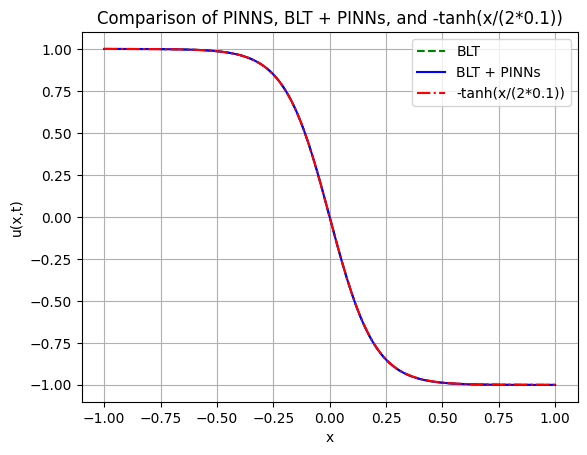

In [114]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from CSV files
blt_data = pd.read_csv('pinns_data.csv')         # PINNS data
blt_pinns_data = pd.read_csv('blt_pinns_data.csv')  # BLT + PINNs hybrid data
tanh01_data = pd.read_csv('tanh01_data.csv')       # Analytical solution (-tanh(x/0.1))

# Plot the solutions
plt.figure()

# Plot the PINNS solution
plt.plot(pinns_data['x'], pinns_data['u(x,t)'], 'g--', label='BLT')

# Plot the BLT + PINNs hybrid solution
plt.plot(blt_pinns_data['x'], blt_pinns_data['u_pinns(x,t)'], 'b-', label='BLT + PINNs')

# Plot the analytical solution (-tanh(x/0.1))
plt.plot(tanh01_data['x'], tanh01_data['u(x)'], 'r-.', label='-tanh(x/(2*0.1))')

# Customize the plot
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Comparison of PINNS, BLT + PINNs, and -tanh(x/(2*0.1))')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [166]:
import numpy as np
import pandas as pd

# Define the BLT (Boundary Layer Theory) solution function
def blt_boundary_layer_solution(x, epsilon):
    return -np.tanh(x / np.sqrt(epsilon))

# Viscosity parameter
epsilon = 0.01

# Define the range of x values (e.g., from -1 to 1)
x_values = np.linspace(-1, 1, 200)  # 200 points between -1 and 1

# Get the BLT solution for each x value
blt_solution = blt_boundary_layer_solution(x_values, epsilon)

# Create a DataFrame to store the x values and the BLT solution
blt_data = pd.DataFrame({
    'x': x_values,
    'u_blt(x)': blt_solution
})

# Save the data to a CSV file
blt_data.to_csv('blt_data.csv', index=False)

print("BLT data saved in 'blt_data.csv'")


BLT data saved in 'blt_data.csv'


In [167]:
import pandas as pd

# Load the data from the CSV files
pinns_data = pd.read_csv('pinns_data.csv')  # File with PINNs data
blt_pinns_data = pd.read_csv('blt_pinns_data.csv')  # File with BLT + PINNs data
tanh_data = pd.read_csv('tanh_data01.csv')  # File with analytical solution data (-tanh(x/0.1))

# Combine the datasets based on the 'x' column (assuming they all share the same x values)
merged_data = pd.merge(pd.merge(pinns_data, blt_pinns_data, on='x'), tanh_data, on='x')

# Check the combined DataFrame
print(merged_data.head())


          x    u(x,t)  u_blt(x)  u_pinns(x,t)  u(x)
0 -1.000000  0.995522       1.0      0.995522   1.0
1 -0.989950  0.995533       1.0      0.995533   1.0
2 -0.979899  0.995543       1.0      0.995543   1.0
3 -0.969849  0.995551       1.0      0.995551   1.0
4 -0.959799  0.995557       1.0      0.995557   1.0


In [168]:
import time

# Measure time for BLT
start_time = time.time()
# Call the function or code block that computes the BLT solution
blt_solution = blt_boundary_layer_solution(X_t[:, 0], epsilon)  # Example for BLT solution
end_time = time.time()
blt_computation_time = end_time - start_time
print(f"Computation time for BLT: {blt_computation_time} seconds")

# Measure time for PINNs
start_time = time.time()
# Call the function or code block that computes the PINNs solution (training process)
model.compile("adam", lr=0.001)
model.train(epochs=5000)
end_time = time.time()
pinns_computation_time = end_time - start_time
print(f"Computation time for PINNs: {pinns_computation_time} seconds")

# Measure time for Hybrid (BLT + PINNs)
start_time = time.time()
# Call the function or code block that computes the hybrid BLT + PINNs solution

end_time = time.time()
hybrid_computation_time = end_time - start_time
print(f"Computation time for Hybrid (BLT + PINNs): {hybrid_computation_time} seconds")


Computation time for BLT: 0.00021648406982421875 seconds
Compiling model...
'compile' took 2.133289 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
5000      [4.87e-01, 1.98e-05, 1.89e-05, 7.76e-06]    [4.87e-01, 1.98e-05, 1.89e-05, 7.76e-06]    []  
6000      [1.50e-03, 1.72e-05, 3.61e-05, 1.78e-03]    [1.50e-03, 1.72e-05, 3.61e-05, 1.78e-03]    []  
7000      [5.70e-04, 1.24e-05, 6.89e-06, 3.89e-04]    [5.70e-04, 1.24e-05, 6.89e-06, 3.89e-04]    []  
8000      [4.75e-04, 7.29e-06, 2.42e-06, 1.76e-04]    [4.75e-04, 7.29e-06, 2.42e-06, 1.76e-04]    []  
9000      [3.87e-04, 3.01e-05, 1.95e-05, 1.46e-04]    [3.87e-04, 3.01e-05, 1.95e-05, 1.46e-04]    []  
10000     [4.99e-04, 4.39e-05, 4.32e-05, 1.37e-04]    [4.99e-04, 4.39e-05, 4.32e-05, 1.37e-04]    []  

Best model at step 3000:
  train loss: 2.42e-05
  test loss: 2.42e-05
  test metric: []

'train' took 92.875807 s

Computation time for PINNs: 95.017

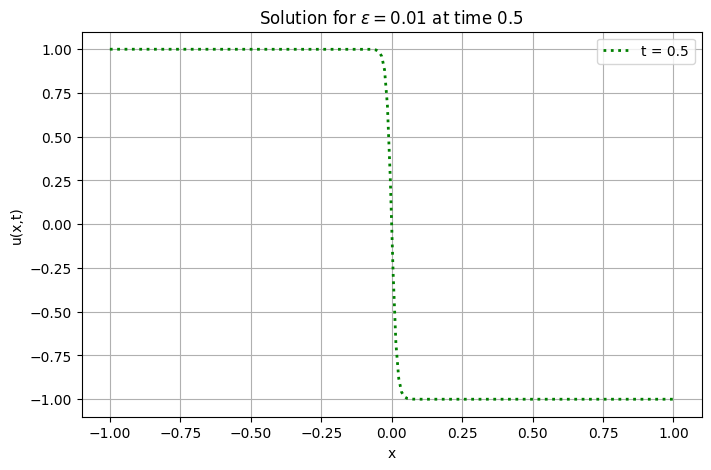

In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
epsilon = 0.01  # Viscosity parameter
L = 2          # Length of the domain [-1, 1]
N = 200        # Number of points in space
dt = 0.0001    # Time step
T = 3          # Maximum time
x = np.linspace(-1, 1, N)  # Space grid

# Initial condition u(x,0) = -tanh(x/0.1)
u = -np.tanh(x / (2*0.01))

# Initialize the solution array
solutions = [u.copy()]

# Function to compute the numerical solution using finite differences
def solve_burgers(u, dt, epsilon, T):
    dx = x[1] - x[0]
    Nt = int(T / dt)

    for n in range(Nt):
        u_new = u.copy()
        for i in range(1, N-1):
            du_x = (u[i+1] - u[i-1]) / (2 * dx)
            du_xx = (u[i+1] - 2 * u[i] + u[i-1]) / dx**2
            u_new[i] = u[i] + dt * (-u[i] * du_x + epsilon * du_xx)

        # Apply boundary conditions
        u_new[0] = np.tanh(1 / (2*0.01))
        u_new[-1] = -np.tanh(1 / (2*0.01))
        u = u_new

        # Store solutions at t = 0, 0.25, and 0.5
        if n * dt in [0, 0.25, 0.5]:
            solutions.append(u.copy())

    return u

# Solve the Burgers' equation
solve_burgers(u, dt, epsilon, T)

# Create a DataFrame with the values of x and the solutions at t = 0.5
data_finite_differences = pd.DataFrame({
    'x': x,           # Column for the x values
    'u(x,t)': solutions[2]  # Column for the u(x,t) values
})

# Save the data to a CSV file with 200 points
file_path_finite_differences = '01finite_differences_data.csv'
data_finite_differences.to_csv(file_path_finite_differences, index=False)

# Visualize all the results at t = 0.5 with the 200 data points from the spatial grid
plt.figure(figsize=(8, 5))
plt.plot(x, solutions[2], 'g:', label='t = 0.5', linewidth=2)
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Solution for $\epsilon = 0.01$ at time 0.5')
plt.legend()
plt.grid(True)
plt.show()


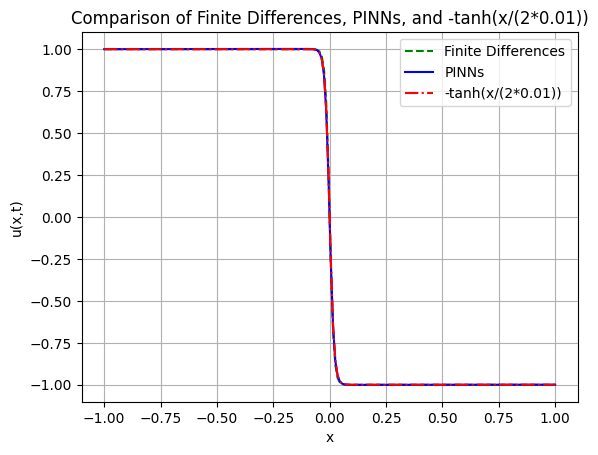

In [170]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV files
finite_differences_data = pd.read_csv('01finite_differences_data.csv')
pinns_data = pd.read_csv('pinns_data01.csv')
tanh_data = pd.read_csv('tanh_data01.csv')

# Plot the solutions
plt.figure()

# Plot the finite differences solution
plt.plot(finite_differences_data['x'], finite_differences_data['u(x,t)'], 'g--', label='Finite Differences')

# Plot the PINNs solution
plt.plot(pinns_data['x'], pinns_data['u(x,t)'], 'b-', label='PINNs')

# Plot the analytical solution (-tanh(x/0.01))
plt.plot(tanh_data['x'], tanh_data['u(x)'], 'r-.', label='-tanh(x/(2*0.01))')

# Customize the plot
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title('Comparison of Finite Differences, PINNs, and -tanh(x/(2*0.01))')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


Compiling model...
Building feed-forward neural network...
'build' took 0.129571 s

'compile' took 5.345468 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.01e-02, 3.73e-01, 3.99e-01, 4.66e-01]    [1.01e-02, 3.73e-01, 3.99e-01, 4.66e-01]    []  
1000      [5.32e-05, 2.99e-07, 2.39e-06, 1.04e-06]    [5.32e-05, 2.99e-07, 2.39e-06, 1.04e-06]    []  
2000      [1.86e-05, 2.05e-08, 2.16e-07, 8.67e-07]    [1.86e-05, 2.05e-08, 2.16e-07, 8.67e-07]    []  
3000      [1.33e-05, 1.22e-06, 2.31e-07, 2.39e-06]    [1.33e-05, 1.22e-06, 2.31e-07, 2.39e-06]    []  
4000      [6.57e-06, 4.42e-08, 5.41e-07, 1.51e-06]    [6.57e-06, 4.42e-08, 5.41e-07, 1.51e-06]    []  
5000      [3.11e-06, 5.41e-09, 3.01e-08, 4.43e-07]    [3.11e-06, 5.41e-09, 3.01e-08, 4.43e-07]    []  

Best model at step 5000:
  train loss: 3.59e-06
  test loss: 3.59e-06
  test metric: []

'train' took 75.278873 s

Compiling model...
Buildin

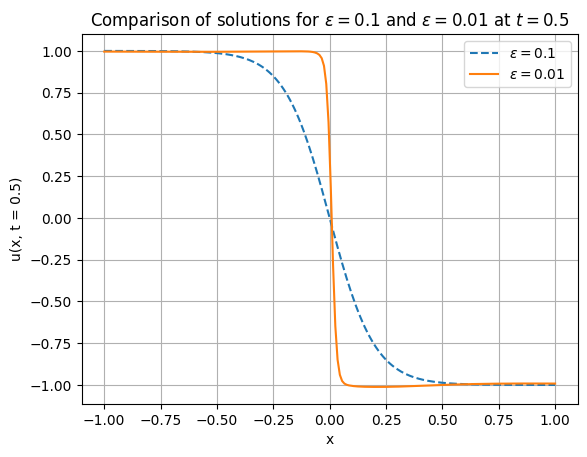

In [171]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

# Define the Burgers' equation with viscosity
def burgers_equation(x, u, epsilon):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Define the spatial and temporal domains
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Define the boundary conditions
bc_left = dde.DirichletBC(geomtime, lambda x: np.array([1]), on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: np.array([-1]), on_boundary=lambda x, _: np.isclose(x[0], 1))

# Initial condition u(x,0)
ic = dde.IC(geomtime, lambda x: -np.tanh(x[:, 0:1] / (2*0.1)), lambda _, on_initial: on_initial)

# Define the problems for epsilon = 0.1 and epsilon = 0.01
epsilons = [0.1, 0.01]
solutions = []

for epsilon in epsilons:
    # Define the problem for each epsilon
    data = dde.data.TimePDE(geomtime, lambda x, u: burgers_equation(x, u, epsilon), [bc_left, bc_right, ic], num_domain=400, num_boundary=40, num_initial=40)

    # Define the neural network
    net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

    # Define the model
    model = dde.Model(data, net)

    # Train the model
    model.compile("adam", lr=0.001)
    model.train(epochs=5000)

    # Generate points for prediction at t = 0.5
    x_vals = np.linspace(-1, 1, 200).reshape(-1, 1)
    t_vals = 0.5 * np.ones_like(x_vals)
    X_test = np.hstack((x_vals, t_vals))
    u_pred = model.predict(X_test)

    solutions.append(u_pred)

# Plot the solutions for epsilon = 0.1 and epsilon = 0.01
plt.figure()
plt.plot(x_vals, solutions[0], label=r"$\epsilon = 0.1$", linestyle='--')
plt.plot(x_vals, solutions[1], label=r"$\epsilon = 0.01$", linestyle='-')
plt.xlabel("x")
plt.ylabel("u(x, t = 0.5)")
plt.legend()
plt.title("Comparison of solutions for $\epsilon = 0.1$ and $\epsilon = 0.01$ at $t = 0.5$")
plt.grid(True)
plt.show()


# Gaussian Profile

Compiling model...
Building feed-forward neural network...
'build' took 0.077087 s

'compile' took 3.053936 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.17e-02, 3.73e-01, 4.03e-01, 2.50e-01]    [1.17e-02, 3.73e-01, 4.03e-01, 2.50e-01]    []  
1000      [2.63e-02, 4.34e-03, 1.09e-02, 3.29e-02]    [2.63e-02, 4.34e-03, 1.09e-02, 3.29e-02]    []  
2000      [6.64e-03, 1.11e-03, 4.92e-04, 8.07e-03]    [6.64e-03, 1.11e-03, 4.92e-04, 8.07e-03]    []  
3000      [2.02e-03, 9.57e-04, 3.05e-04, 3.10e-03]    [2.02e-03, 9.57e-04, 3.05e-04, 3.10e-03]    []  
4000      [1.56e-03, 8.15e-04, 2.44e-04, 2.21e-03]    [1.56e-03, 8.15e-04, 2.44e-04, 2.21e-03]    []  
5000      [1.62e-03, 6.95e-04, 2.38e-04, 1.59e-03]    [1.62e-03, 6.95e-04, 2.38e-04, 1.59e-03]    []  

Best model at step 5000:
  train loss: 4.15e-03
  test loss: 4.15e-03
  test metric: []

'train' took 67.256377 s

Compiling model...
Buildin

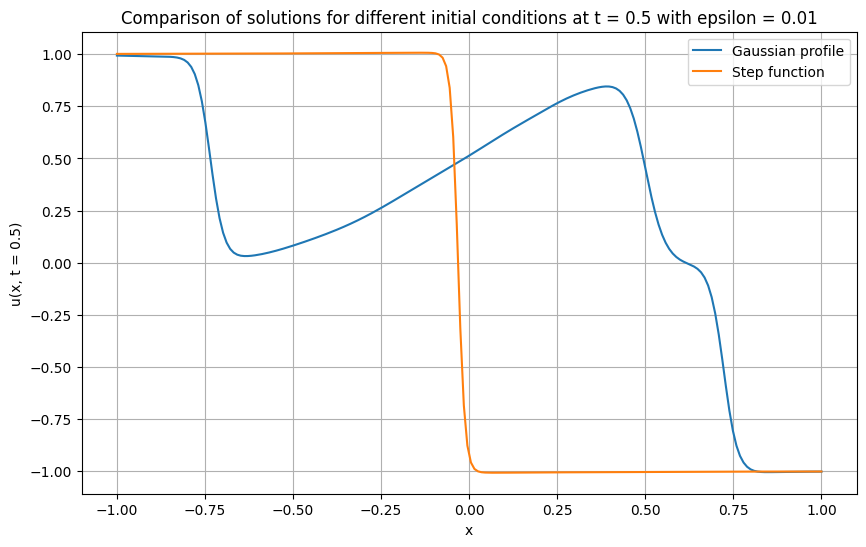

In [172]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

# Parameter for the equation
epsilon = 0.01  # Viscosity

# Define the Burgers' equation with viscosity
def burgers_equation(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)  # u_t
    u_x = dde.grad.jacobian(u, x, i=0, j=0)  # u_x
    u_xx = dde.grad.hessian(u, x, i=0, j=0)  # u_xx
    return u_t + u * u_x - epsilon * u_xx

# Define the spatial and temporal domains
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Define the boundary conditions
bc_left = dde.DirichletBC(geomtime, lambda x: np.array([1]), on_boundary=lambda x, _: np.isclose(x[0], -1))
bc_right = dde.DirichletBC(geomtime, lambda x: np.array([-1]), on_boundary=lambda x, _: np.isclose(x[0], 1))

# Define the initial condition: Gaussian profile
def gaussian_ic(x):
    return np.exp(-10 * (x[:, 0:1])**2)  # Gaussian initial condition

# Define the initial condition: step function
def step_function_ic(x):
    return np.where(x[:, 0:1] < 0, 1.0, -1.0)  # Step function initial condition

# Create a list of initial conditions (Gaussian and step function)
initial_conditions = [gaussian_ic, step_function_ic]
initial_labels = ["Gaussian profile", "Step function"]
solutions = []

# Run simulations for both initial conditions
for ic_func in initial_conditions:
    # Define the initial condition for the current case
    ic = dde.IC(geomtime, ic_func, lambda _, on_initial: on_initial)

    # Define the problem
    data = dde.data.TimePDE(geomtime, burgers_equation, [bc_left, bc_right, ic], num_domain=400, num_boundary=40, num_initial=40)

    # Define the neural network
    net = dde.maps.FNN([2] + [50] * 3 + [1], "tanh", "Glorot uniform")

    # Define the model
    model = dde.Model(data, net)

    # Train the model
    model.compile("adam", lr=0.001)
    model.train(epochs=5000)

    # Generate points for prediction at t = 0.5
    x_vals = np.linspace(-1, 1, 200).reshape(-1, 1)
    t_vals = 0.5 * np.ones_like(x_vals)
    X_test = np.hstack((x_vals, t_vals))
    u_pred = model.predict(X_test)

    solutions.append(u_pred)

# Plot the solutions for both initial conditions
plt.figure(figsize=(10, 6))
for i, label in enumerate(initial_labels):
    plt.plot(x_vals, solutions[i], label=label)
plt.xlabel("x")
plt.ylabel("u(x, t = 0.5)")
plt.legend()
plt.title("Comparison of solutions for different initial conditions at t = 0.5 with epsilon = 0.01")
plt.grid(True)
plt.show()


In [122]:
import base64
from IPython.display import Image, display

def mm(graph):
    graphbytes = graph.encode("utf8")
    base64_bytes = base64.urlsafe_b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    display(Image(url="https://mermaid.ink/img/" + base64_string))

mm("""
graph TD
    A[Start Process] --> B[Apply BLT for Initial Conditions]
    A --> C[Define PINNs Model]
    B --> D[Set Initial and Boundary Conditions with BLT]
    D --> E[Combine BLT and PINNs]
    C --> E
    E --> F[Train with Adam Optimizer]
    F --> G[Fine-tune with L-BFGS Optimizer]
    G --> H[Make Predictions]
    H --> I[Compare Predictions with Exact Solution]
    I --> J[Calculate L2 Error and Training Time]
    J --> K[Show Comparative Graph]
    J --> L[Show Error and Time Table]
""")
